# Inverse Estimation

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import os, re, sys

import pickle as pkl
from pydemic import Pandemic, Outbreak

from scipy.stats import weibull_min
from skopt import Optimizer, dump, load
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, partial_dependence
from skopt.space import Real

import seaborn as sns

from tabulate import tabulate

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize']=[40,20]

plt.style.use('seaborn-whitegrid')

### Setup

In [7]:
coronavirus_confirmed_df = pd.read_csv("../data/clean/coronavirus_confirmed_global.csv", index_col=0)
coronavirus_death_df = pd.read_csv("../data/clean/coronavirus_death_global.csv", index_col=0)
coronavirus_recovered_df = pd.read_csv("../data/clean/coronavirus_recovered_global.csv", index_col=0)

In [152]:
pandemic = Pandemic("Coronavirus", coronavirus_confirmed_df, coronavirus_death_df, coronavirus_recovered_df)
pandemic.set_smoothing_coefficient(3)


## Estimator Classes

### Estimate Errors

In [11]:
def naive_error(realization, estimate):
    return realization - estimate

def scale_free_error(realization, estimate):
    errors = naive_error(realization, estimate)
    scale_coefficient = np.mean(np.abs(np.diff(realization)))
    
    return errors / scale_coefficient

def mean_absolute_error(realization, estimate, error=naive_error):
    errors = error(realization, estimate)
    
    return np.mean(np.abs(errors))

### Estimator Helpers

In [328]:
def build_logger(verbose, prefix="default"):
    def _silent_log(s): None
    def _log(s): print(f"{prefix}:", s)
        
    return _log if verbose else _silent_log

### Estimator Optimizer

In [ ]:
class OutbreakEstimatorOptimizer:
    def __init__(self, estimator, random_state=1):
        self.estimator = estimator
        self.random_state = random_state
        
    def _init_evaluator(self):
        def _evaluate(alpha, beta, lam):
            try:
                self.estimator.set_parameters(alpha, beta, lam)
            except InvalidHazardRateException:
                # return a much larger number to discourage the combination in later iterations
                return 1_000
            
            estimate = self._estimate()
            realization = self.deaths
            
            if self.cumulative_error:
                estimate = np.cumsum(estimate)
                realization = np.cumsum(realization)
            
            return mean_absolute_error(realization, estimate, error=self.error)
        
        self._evaluate = _evaluate
    
    def _optimize_parameters(self, dimensions=None, n_runs=100, n_random_starts=10, n_jobs=4, exploration_exploitation_coefficient=5, **kwargs):
        dimensions = dimensions if dimensions else [Real(0.01, 0.20), Real(0.5, 10.0, OutbreakEstimator.BETA), Real(1.0, 20.0, OutbreakEstimator.LAMBDA)]
        
        self.optimizer = Optimizer(
            acq_optimizer="lbfgs", 
            acq_func_kwargs={
                "xi": exploration_exploitation_coefficient, 
                "kappa": exploration_exploitation_coefficient
            },
            random_state=self.random_state, 
            dimensions=dimensions, 
            n_random_starts=n_random_starts,
            **kwargs
        )
        
        self.log("Optimization started.")
        
        for iter_id in range(n_runs):
            x = self.optimizer.ask()
            
            distance = self._evaluate(*x)
            
            self.optimizer.tell(x, distance)
            
            self.log(f"Iteration #{iter_id}: {distance} ({x[0]}, {x[1]}, {x[2]})")
            
        self.log("Optimization finished.")
            
    
    # return (or load) the skopt result for the current configuration
    @property
    def optimizer_result(self):
        if self._optimizer_result is None:
            if self.optimizer is None:
                self._optimizer_result = self.load_result()
            else:
                self._optimizer_result = self.optimizer.get_result()
        
        return self._optimizer_result
            
    @property
    def _configuration_prefix(self):
        prefix = []
        
        prefix.append(str(self.T) if self.T > 0 else "full")
        prefix.append("cumulative" if self.cumulative_error else "daily")
        prefix.append("scaled_error" if self.error == scale_free_error else "naive_error")
        
        return "_".join(prefix)
    
    def load_result(self, path="coronavirus"):
        if os.path.isfile(f"../results/{path}/{self.outbreak.region}/{self._configuration_prefix}_optimization_result.pkl"):
            return load(f"../results/{path}/{self.outbreak.region}/{self._configuration_prefix}_optimization_result.pkl")
        
        return None
            
    def save_result(self, path="coronavirus"):
        if self.optimizer is None: return False
        
        if os.path.isdir(f"../results/{path}/{self.outbreak.region}") is False:
            os.mkdir(f"../results/{path}/{self.outbreak.region}")
            
        dump(self.optimizer.get_result(),  f"../results/{path}/{self.outbreak.region}/{self._configuration_prefix}_optimization_result.pkl")

In [321]:
class InvalidHazardRateException(Exception): pass
class MissingOutbreakException(Exception): pass
class ExistingOutbreakException(Exception): pass

class OutbreakEstimator(ABC):
    # from previous study
    BETA = 1.8429282373343958
    LAMBDA = 10.018568258846706
    
    """
    The OubreakEstimator abstract class provides a common foundation to build the different estimators devised for the study.
    
    The main parameters for the estimators are:
    
        - alpha: CFR
        - beta: Weibull shape
        - lambda: Weibull scale (called `lam` due to the Python primitive)
        
    There are also optional parameters:
        
        - n_days_cutoff: days to leave out for testing (used for cross-validation)
        - warm_start: whether the model should only predict the daily fatality curve after `warm_start_min_deaths_observed` cumulative deaths have been seen.
        - error: error method between realization and estimate to be used on the daily curve (or cumulative curve).
    
    """
    def __init__(self, alpha=0.15, beta=2.5, lam=13, **kwds):
        self.alpha, self.beta, self.lam = alpha, beta, lam
        
        self.T = 0
        self.n_days_cutoff = n_days_cutoff
        
        self.verbose = verbose
        
        self.warm_start = warm_start
        self.warm_start_min_deaths_observed = warm_start_min_deaths_observed
        
        self.error = error
        self.cumulative_error = cumulative_error
        
        self.optimizer = None
        self._optimizer_result = None
    
        self._estimate_cache = {}
        
        self.log = build_logger(verbose)
        
        # Optimizer
    
    def fit(self, outbreak, skip_optimization=False, n_days_cutoff=0, verbose=False, warm_start=True, warm_start_min_deaths_observed=10, cumulative_error=False, error=scale_free_error, **kwargs):
        if outbreak is not None:
            raise ExistingOutbreakException
            
        self.outbreak = outbreak
        
        self._init_data()
        self._init_evaluator()
        self._update_model()
        
        if skip_optimization is not True:
            self._optimize_parameters(**kwargs)
            
    def predict(self):
        if self.outbreak is None:
            raise MissingOutbreakException
            
        if self.T == self.outbreak.duration:
            return []
        
#         testing_data = self.outbreak.cases
        
    def _init_data(self):
        self.T = self.outbreak.duration - self.n_days_cutoff
        
        # apply warm start
        self.t0 = self.outbreak.ffx_deaths(self.warm_start_min_deaths_observed)[0] if self.warm_start else 0
        
        self.cases = self.outbreak.epidemic_curve[:self.T]
        self.deaths = self.outbreak.fatality_curve[self.t0:self.T]
            
    def _init_evaluator(self):
        if self.outbreak is None: 
            raise MissingOutbreakException
            
        def _evaluate(alpha, beta, lam):
            try:
                self.set_parameters(alpha, beta, lam)
            except InvalidHazardRateException:
                # return a much larger number to discourage the combination in later iterations
                return 1_000
            
            estimate = self._estimate()
            realization = self.deaths
            
            if self.cumulative_error:
                estimate = np.cumsum(estimate)
                realization = np.cumsum(realization)
            
            return mean_absolute_error(realization, estimate, error=self.error)
        
        self._evaluate = _evaluate
            
    def _build_hazard_rate(self, ppf_end=0.999):
        W = weibull_min(self.beta, scale=self.lam)
        self.K = int(W.ppf(ppf_end))
        
        if self.K == 0: raise InvalidHazardRateException

        x = np.arange(self.K)
        
        # set fatality rate
        self.fatality_rate = W.cdf(x + 0.5) - W.cdf(x - 0.5)
        cumulative_fatality_rate = np.cumsum(self.fatality_rate)

        # set hazard rate
        self.hazard_rate = np.zeros(self.K)
        self.hazard_rate[0] = self.fatality_rate[0]
        self.hazard_rate[1:] = self.fatality_rate[1:] / (1 - cumulative_fatality_rate[:-1])

    # Properties
        
    @property
    def parameters(self):
        return (self.alpha, self.beta, self.lam)
        
    def set_parameters(self, alpha, beta, lam):
        if self.alpha == alpha and self.beta == beta and self.lam == lam:
            return
        
        self.alpha, self.beta, self.lam = alpha, beta, lam
        
        self._update_model()
        
    @property
    def best_parameters(self):
        return self.optimizer_result.x if self.optimizer_result else (None, None, None)
    
    @property
    def best_parameters_error(self):
        return self.optimizer_result.fun if self.optimizer_result else None
    
    def _optimize_parameters(self, dimensions=None, n_runs=100, n_random_starts=10, n_jobs=4, exploration_exploitation_coefficient=5, **kwargs):
        if self.outbreak is None:
            raise MissingOutbreakException
            
        dimensions = dimensions if dimensions else [Real(0.01, 0.20), Real(0.5, 10.0, OutbreakEstimator.BETA), Real(1.0, 20.0, OutbreakEstimator.LAMBDA)]
        
        self.optimizer = Optimizer(
            acq_optimizer="lbfgs", 
            acq_func_kwargs={
                "xi": exploration_exploitation_coefficient, 
                "kappa": exploration_exploitation_coefficient
            },
            random_state=self.random_state, 
            dimensions=dimensions, 
            n_random_starts=n_random_starts,
            **kwargs
        )
        
        self.log("Begin fitting...")
        for iter_id in range(n_runs):
            x = self.optimizer.ask()
            
            distance = self._evaluate(*x)
            
            self.optimizer.tell(x, distance)
            
            self.log(f"Iteration #{iter_id}: {distance} ({x[0]}, {x[1]}, {x[2]})")
            
    
    # return (or load) the skopt result for the current configuration
    @property
    def optimizer_result(self):
        if self._optimizer_result is None:
            if self.optimizer is None:
                self._optimizer_result = self.load_result()
            else:
                self._optimizer_result = self.optimizer.get_result()
        
        return self._optimizer_result
            
    @property
    def _configuration_prefix(self):
        prefix = []
        
        prefix.append(str(self.T) if self.T > 0 else "full")
        prefix.append("cumulative" if self.cumulative_error else "daily")
        prefix.append("scaled_error" if self.error == scale_free_error else "naive_error")
        
        return "_".join(prefix)
    
    def load_result(self, path="coronavirus"):
        if os.path.isfile(f"../results/{path}/{self.outbreak.region}/{self._configuration_prefix}_optimization_result.pkl"):
            return load(f"../results/{path}/{self.outbreak.region}/{self._configuration_prefix}_optimization_result.pkl")
        
        return None
            
    def save_result(self, path="coronavirus"):
        if self.optimizer is None: return False
        
        if os.path.isdir(f"../results/{path}/{self.outbreak.region}") is False:
            os.mkdir(f"../results/{path}/{self.outbreak.region}")
            
        dump(self.optimizer.get_result(),  f"../results/{path}/{self.outbreak.region}/{self._configuration_prefix}_optimization_result.pkl")
    
    # Investiagion
    
    def plot_estimates(self, savefig=False):
        fig, axes = plt.subplots(ncols=2, nrows=2)
        
        fig.suptitle(self.outbreak.region)
        
        self.set_parameters(*self.best_parameters)
        
        ax = axes[0][0]
        
        ax.set_title("Daily Fatality Estimates")
        ax.set_xlabel("Days since outbreak began (t)")
        ax.set_ylabel("Number of Deaths (d_t)")
        
        estimate = self._estimate()
        
        ax.plot(self.deaths.values, label="d")
        ax.plot(estimate, c='red', lw=3, label="d_hat")
        
        ax = axes[0][1]
        
        ax.set_title("Cumulative Fatality Estimates")
        ax.set_xlabel("Days since outbreak began (t)")
        ax.set_ylabel("Number of Deaths (d_t)")
        
        ax.plot(np.cumsum(self.deaths.values), label="d")
        ax.plot(np.cumsum(estimate), c='red', lw=3, label="d_hat")
        
        ax = axes[1][0]
        
        ax.set_title("Case Fatality Density")
        ax.set_xlabel("Days since infection confirmation (k)")
        ax.set_ylabel("Probability of Death | Death")
        
        ax.plot(self.fatality_rate, label="Fatality density")
        ax.plot(self.hazard_rate, label="Hazard rate")
        
        ax.legend()
        
        ax = axes[1][1]
        
        ax.set_title("Convergence")
        ax.set_xlabel("MASE")
        ax.set_ylabel("Iterations")
        
        plot_convergence(self.optimizer_result, dimensions=["alpha", "beta", "lambda"], ax=ax)
        
        if savefig:
            plt.savefig(f"../plots/analytical/pruned_opt/{region}/{self._configuration_prefix}_estimates.pdf")
            
        plt.show()
        
    def plot_optimization_result(self):
        fig, axes = plt.subplots(ncols=2, nrows=2)
        
        plt.suptitle(self.outbreak.region)
        
        dimensions = ["alpha", "beta", "lambda"]
        
        ax = axes[0][0]
        
        ax.set_title("Daily Fatality Estimates")
        ax.set_xlabel("Days since outbreak began (t)")
        ax.set_ylabel("Number of Deaths (d_t)")
        
        estimate = self._estimate()
        
        self.plot_estimate()
        
        ax = axes[0][1]

        ax.set_title(f"Objective")
        plot_objective(self.optimizer_result, dimensions=dimensions, ax=ax)
        
        ax = axes[1][0]

        ax.set_title(f"Convergence")
        axes = plot_convergence(self.optimizer_result, dimensions=dimensions, ax=ax)
        
        ax = axes[1][1]
        
        plt.savefig(f"../plots/analytical/pruned_opt/{region}_optimization_results.pdf")
        plt.show()

    # Abstract Methods
    
    @abstractmethod
    def _update_model(self):
        self._build_hazard_rate()
    
    @abstractmethod
    def _estimate(self, **kwargs):
        pass

### Simulation-based Fatality Forecast

In [317]:
class SimulationFatalityEstimator(OutbreakEstimator):
    def __init__(self, *args, n_sims=1000, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_sims = n_sims
        self._simulation_cache = {}
        
    def _update_model(self):
        super()._update_model()
        
    def _simulate_outcomes(self, n_cases):
        probability_samples = np.random.rand(n_cases, self.K + 1)

        fatality_bitmask = probability_samples[:, 0] < self.alpha
        # argmax returns the index of the first "True" in an array of booleans
        fatality_delays = np.argmax(probability_samples[:, 1:] < self.hazard_rate, axis=1)

        return fatality_delays, fatality_bitmask

    def _estimate(self, overwrite=False):
        # perform calculations if necessary
        if overwrite or self.parameters not in self._simulation_cache:        
            fatalities = np.zeros((self.n_sims, self.T))

            # simulate every day of the outbreak
            for t, n_cases in enumerate(self.cases.astype(int)):
                fatality_delays, fatality_bitmask = self._simulate_outcomes(n_cases * self.n_sims)

                for sim in range(self.n_sims):
                    sim_ptr = n_cases * sim

                    # get fatality delays and fatality bitmask for sim 
                    sim_fatality_delays = fatality_delays[sim_ptr: sim_ptr + n_cases]
                    sim_fatality_bitmask = fatality_bitmask[sim_ptr: sim_ptr + n_cases]

                    # reduce fatality delays to fatality tolls per day
                    sim_fatality_days = np.bincount(sim_fatality_delays[sim_fatality_bitmask])
                    
                    # censor results to avoid index out of bounds
                    censoring = min(sim_fatality_days.shape[0], self.T - t)

                    # add fatality tolls per date to simulation counts
                    fatalities[sim, t:(t + censoring)] += sim_fatality_days[:censoring]

            # update caches
            self._simulation_cache[self.parameters] = fatalities[:, self.t0:]
            self._estimate_cache[self.parameters] = np.mean(self._simulation_cache[self.parameters], axis=0)
                
        return self._estimate_cache[self.parameters]

# class OutbreakDualSimulator(OutbreakEstimator):
#     def run(self, n_sims=1000):
#         self._simulate_outbreak(self.cases, self.alpha, self.hazard_rate, n_sims=n_sims)
    
#     @staticmethod
#     def _simulate_outcomes(n_cases, fatality_probability, fatality_hazard_rate, recovery_hazard_rate):
#         K = fatality_hazard_rate.shape[0]

#         probability_samples = np.random.rand(n_cases, K + 1)

#         fatality_bitmask = probability_samples[:, 0] < fatality_probability

#         fatality_outcome_days = np.argmax(probability_samples[fatality_probability, 1:] < fatality_hazard_rate, axis=1)
#         # use the inverse to make sure the two events are exclusive
#         recorvey_outcome_days = np.argmax(probability_samples[~fatality_probability, 1:] > 1 - recovery_hazard_rate, axis=1)

#         # assumption: if fatality/recovery occurs the same day, the fatality takes precendence
#         # fatality_bitmask = fatality_outcomes <= recovery_outcomes
#         # outcome_days = np.minimum(fatality_outcomes, recovery_outcomes)

#         return fatality_outcome_days, recorvey_outcome_days, fatality_bitmask

#     @staticmethod
#     def _simulate_outbreak(cases, fatality_probability, fatality_hazard_rate, recovery_hazard_rate, n_sims=100):
#         T = cases.shape[0]
#         K = hazard_rate.shape[0]

#         fatalities = np.zeros((n_sims, T))
#         recoveries = np.zeros((n_sims, T)) 

#         for t, n_cases in enumerate(cases.astype(int)):
#             fatality_outcome_days, recorvey_outcome_days, fatality_bitmask = simulate_cases(int(n_cases * n_sims), fatality_hazard_rate, recovery_hazard_rate)
#             n_recoveries = (~fatality_bitmask).sum()

#             for sim in range(n_sims):
#                 sim_outcome_days = outcome_days[n_cases * sim: n_cases * (sim + 1)]
#                 sim_fatality_bitmask = fatality_bitmask[n_cases * sim: n_cases * (sim + 1)]

#                 deaths_per_day = np.bincount(sim_outcome_days[sim_fatality_bitmask])
#                 censoring = min(deaths_per_day.shape[0], T - t)

#                 fatalities[sim, t:(t + censoring)] += deaths_per_day[:censoring]

#         return fatalities, recoveries

## Analytical Estimators

In [323]:
class AnalyticalFatalityEstimator(OutbreakEstimator):
    def fatality_gradient(t):
        return self.alpha * (self.support_vectors[t + 1, 0] + (self.phi - 1).dot(self.support_vectors[t, :-1]))
    
    def _forecast(self, t, days):
        assert (t + 1) + days < self.oubreak.duration
        
        # construct the support vectors necessary for the entire outbreak
        self._build_support_vectors(self.oubreak.duration, self.K)
        
        d_t = self.outbreak.deaths[t]
        
#         real_total_deaths = sum(self.outbreak.deaths[(t + 1):(t + 1) + days])
        forecasted_deaths = d_t + sum(fatality_gradient(t + k) for k in range(days))
        
        # return model to previous state
        self._update_model()
        
        return forecasted_deaths
        
    def _estimate(self, overwrite=False):
        if overwrite or self.parameters not in self._estimate_cache:
            estimate = self.alpha * np.sum(self.support_vectors, axis=1)

            self._estimate_cache[self.parameters] = estimate[self.t0:]
        
        return self._estimate_cache[self.parameters]
        
    def _update_model(self):
        super()._update_model()
        self._build_support_vectors(self.T, self.K)
        self._build_phi(self.K)
        
    def _build_support_vectors(self, T, K):
        self.support_vectors = np.zeros((T, K))
        
        cumulative_survival_probability = np.cumprod(1 - self.hazard_rate)

        for t in range(1, T):
            for i in range(min(t, K)):
                self.support_vectors[t, i] = self.hazard_rate[i] * self.cases[t - i]

                if i >= 1:
                    self.support_vectors[t, i] *= cumulative_survival_probability[i - 1]

    def _build_phi(self, K):
        self.phi = np.zeros(K - 1)

        for k in range(K - 1):
            self.phi[k] = self.fatality_rate[k + 1] / self.fatality_rate[k]

### Naive Fitting

We naively fit the Top 20 countries considered over wide parameter bounds. This initial fit serves to prune those countries for which our model is not ideal. The scatterplot shown below displays two clear clusters of countries by CFR and MASE values around the 5% and 13% ranges. The few outliers are composed of Saudi Arabia, Turkey, Russia, UK, India...

In [274]:
top20_countries = pandemic.get_top_regions(top_n=20, exclude=["Saudi Arabia", "Turkey", "Russia", "Iran", "China"])

In [281]:
top20_estimates_df = pd.DataFrame(columns=["region", "cumulative_error", "cutoff", "alpha", "beta", "lambda", "MASE"])

In [284]:
ptr = 0

for region, outbreak in pandemic.get_outbreaks(top20_countries).items():
    print(f"Fitting for {region}: full")
    
    # Full (Daily)
    model = AnalyticalFatalityEstimator()
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, False, 0, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    # Full (Cumulative)
    model = AnalyticalFatalityEstimator(cumulative_error=True)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, True, 0, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    print(f"Fitting for {region}: 3-days")
    # 3-days (Daily)
    model = AnalyticalFatalityEstimator(T=3)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, False, 3, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    # 3-days (Cumulative)
    model = AnalyticalFatalityEstimator(T=3, cumulative_error=True)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, True, 3, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    print(f"Fitting for {region}: 7-days")
    # 7-days (Daily)
    model = AnalyticalFatalityEstimator(T=7)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, False, 7, *model.best_parameters, model.best_parameters_error]
    ptr += 1
    
    # 7-days (Cumulative)
    model = AnalyticalFatalityEstimator(T=7, cumulative_error=True)
    model.fit(outbreak)
    model.save_result()
    
    top20_estimates_df.loc[ptr, :] = [region, True, 7, *model.best_parameters, model.best_parameters_error]
    ptr += 1

Fitting for Belgium: full
Fitting for Belgium: 3-days
Fitting for Belgium: 7-days
Fitting for Brazil: full
Fitting for Brazil: 3-days
Fitting for Brazil: 7-days
Fitting for Canada: full
Fitting for Canada: 3-days
Fitting for Canada: 7-days
Fitting for Chile: full
Fitting for Chile: 3-days
Fitting for Chile: 7-days
Fitting for Ecuador: full
Fitting for Ecuador: 3-days
Fitting for Ecuador: 7-days
Fitting for France: full
Fitting for France: 3-days
Fitting for France: 7-days
Fitting for Germany: full
Fitting for Germany: 3-days
Fitting for Germany: 7-days
Fitting for India: full
Fitting for India: 3-days
Fitting for India: 7-days
Fitting for Ireland: full
Fitting for Ireland: 3-days
Fitting for Ireland: 7-days
Fitting for Italy: full
Fitting for Italy: 3-days
Fitting for Italy: 7-days
Fitting for Mexico: full


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Mexico: 3-days
Fitting for Mexico: 7-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Netherlands: full


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Netherlands: 3-days
Fitting for Netherlands: 7-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Pakistan: full
Fitting for Pakistan: 3-days
Fitting for Pakistan: 7-days
Fitting for Peru: full
Fitting for Peru: 3-days
Fitting for Peru: 7-days
Fitting for Portugal: full
Fitting for Portugal: 3-days
Fitting for Portugal: 7-days
Fitting for Spain: full
Fitting for Spain: 3-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Spain: 7-days
Fitting for Sweden: full


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

Fitting for Sweden: 3-days
Fitting for Sweden: 7-days


/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/rafa/opt/anaconda3/envs/coronavirus/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting for Switzerland: full
Fitting for Switzerland: 3-days
Fitting for Switzerland: 7-days
Fitting for US: full
Fitting for US: 3-days
Fitting for US: 7-days
Fitting for United Kingdom: full
Fitting for United Kingdom: 3-days
Fitting for United Kingdom: 7-days


In [315]:
top20_estimates_df.to_csv("../results/coronavirus/top20_estimates.csv")

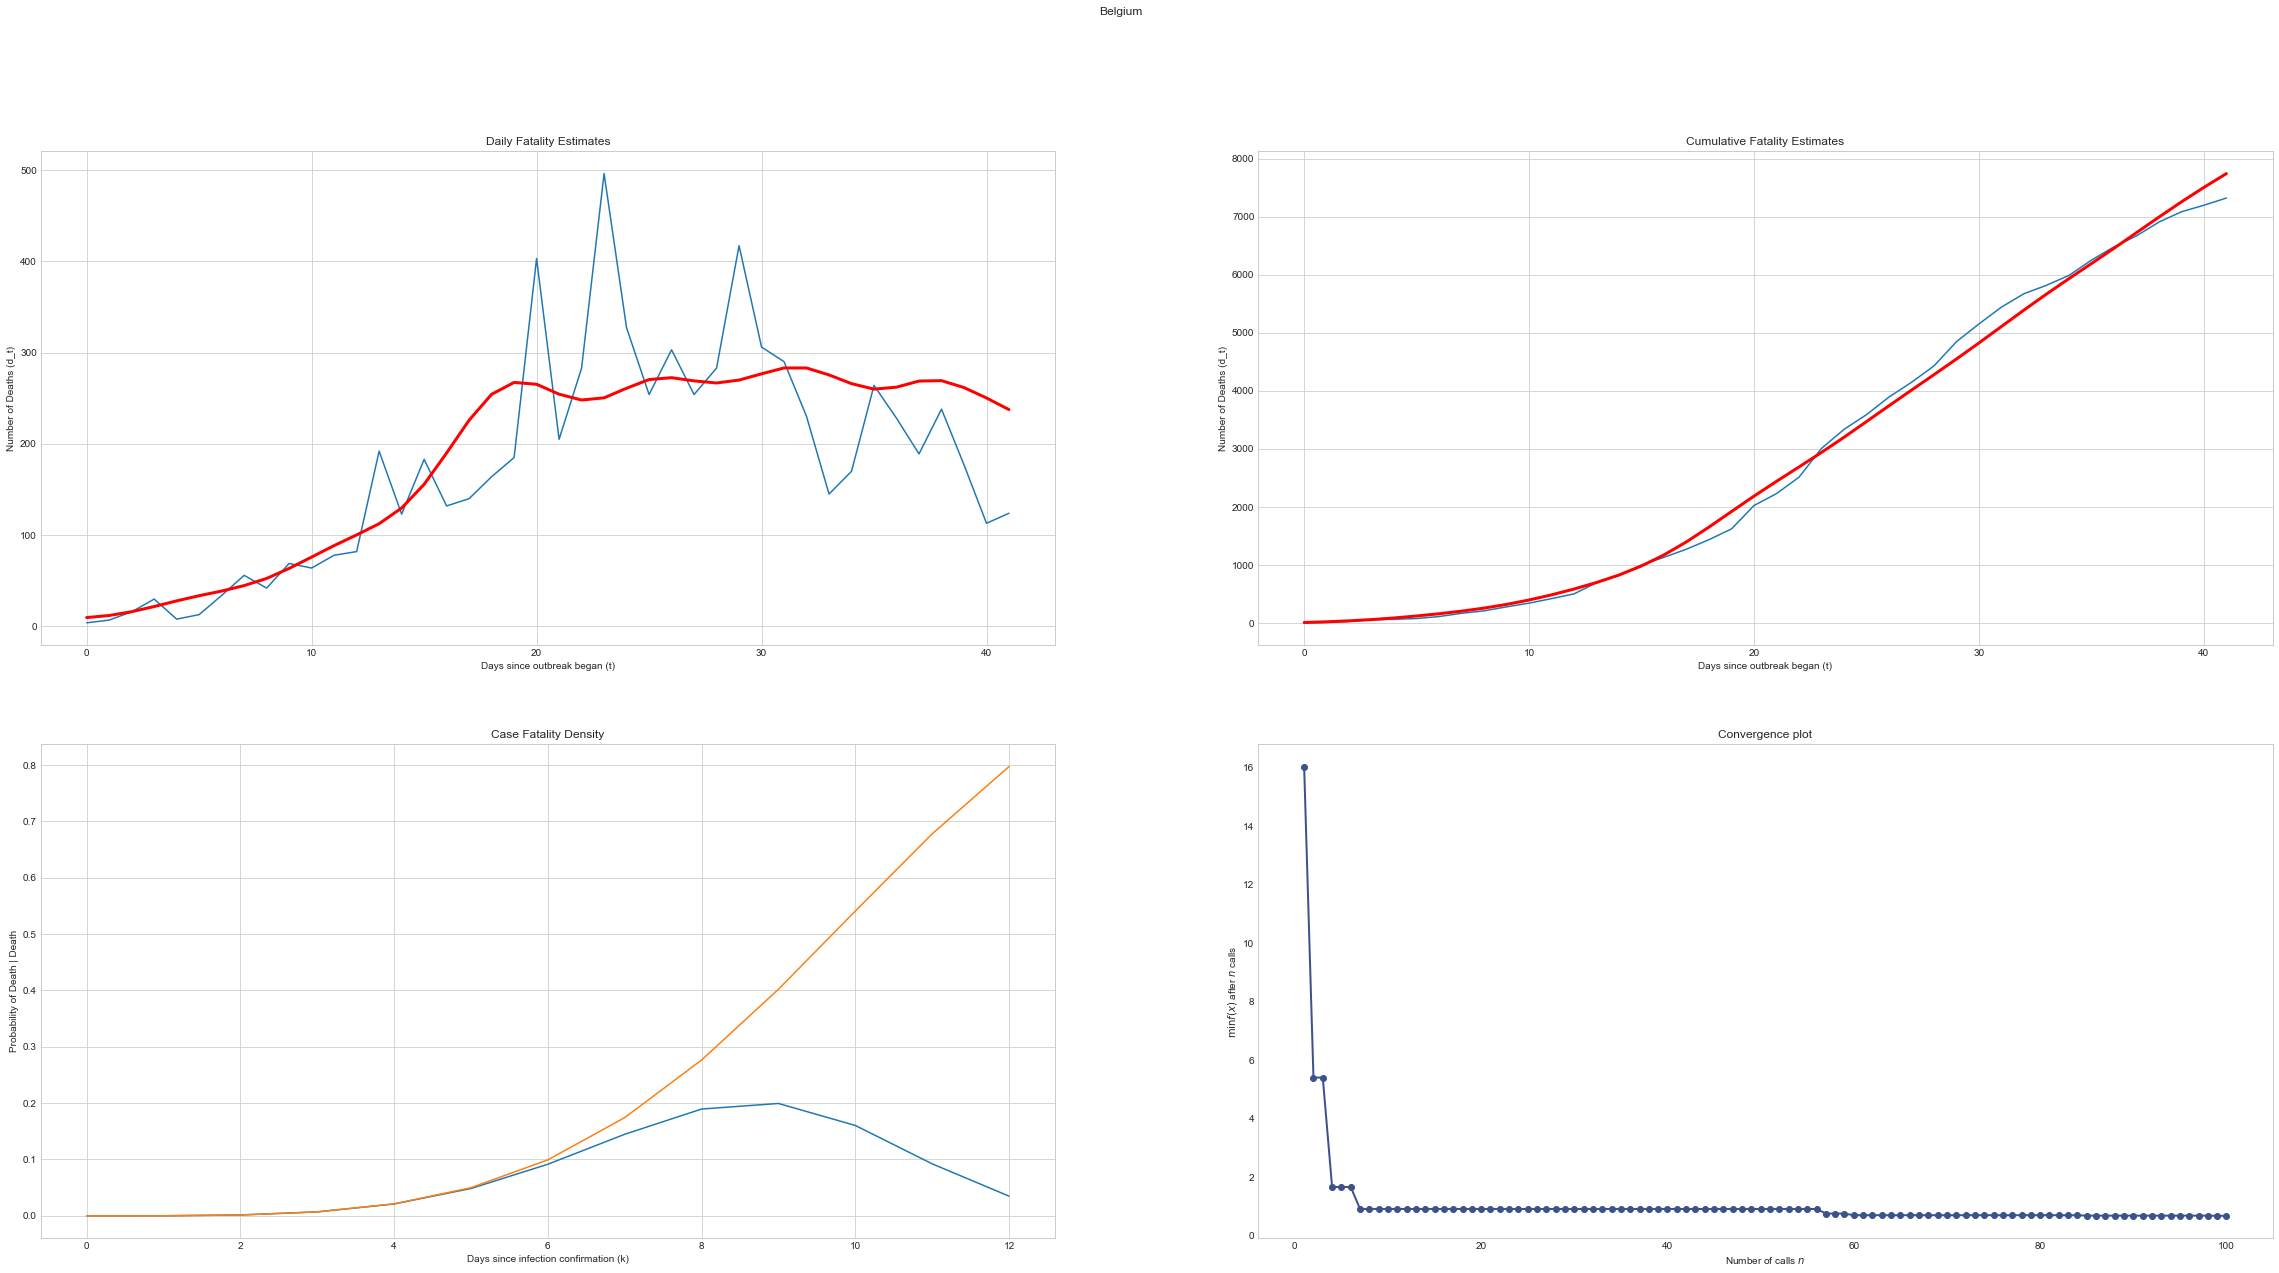

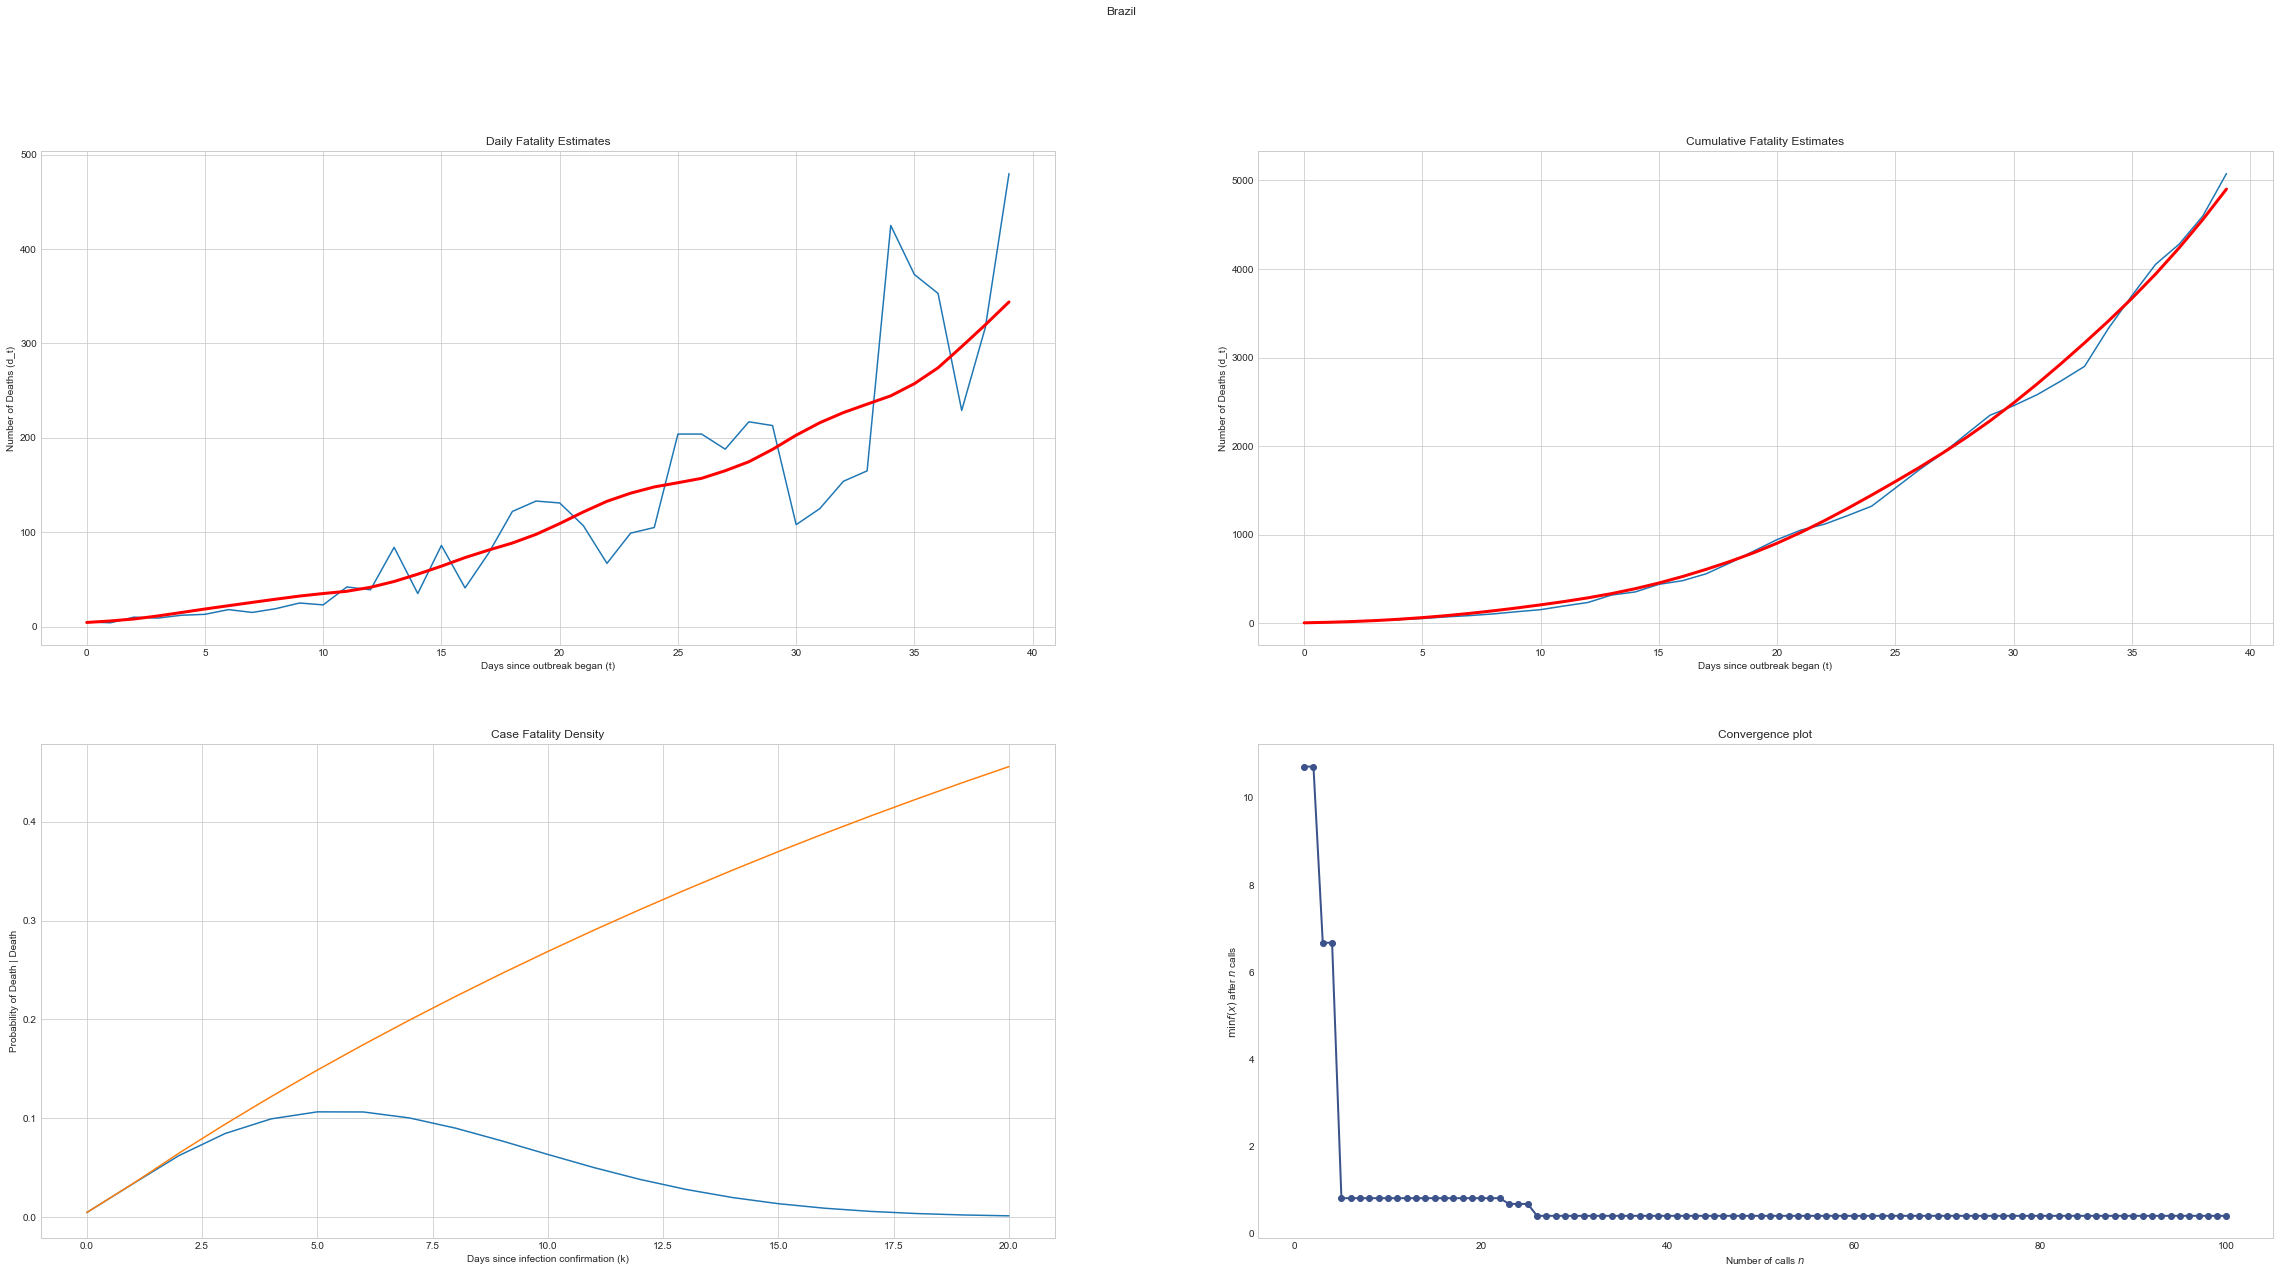

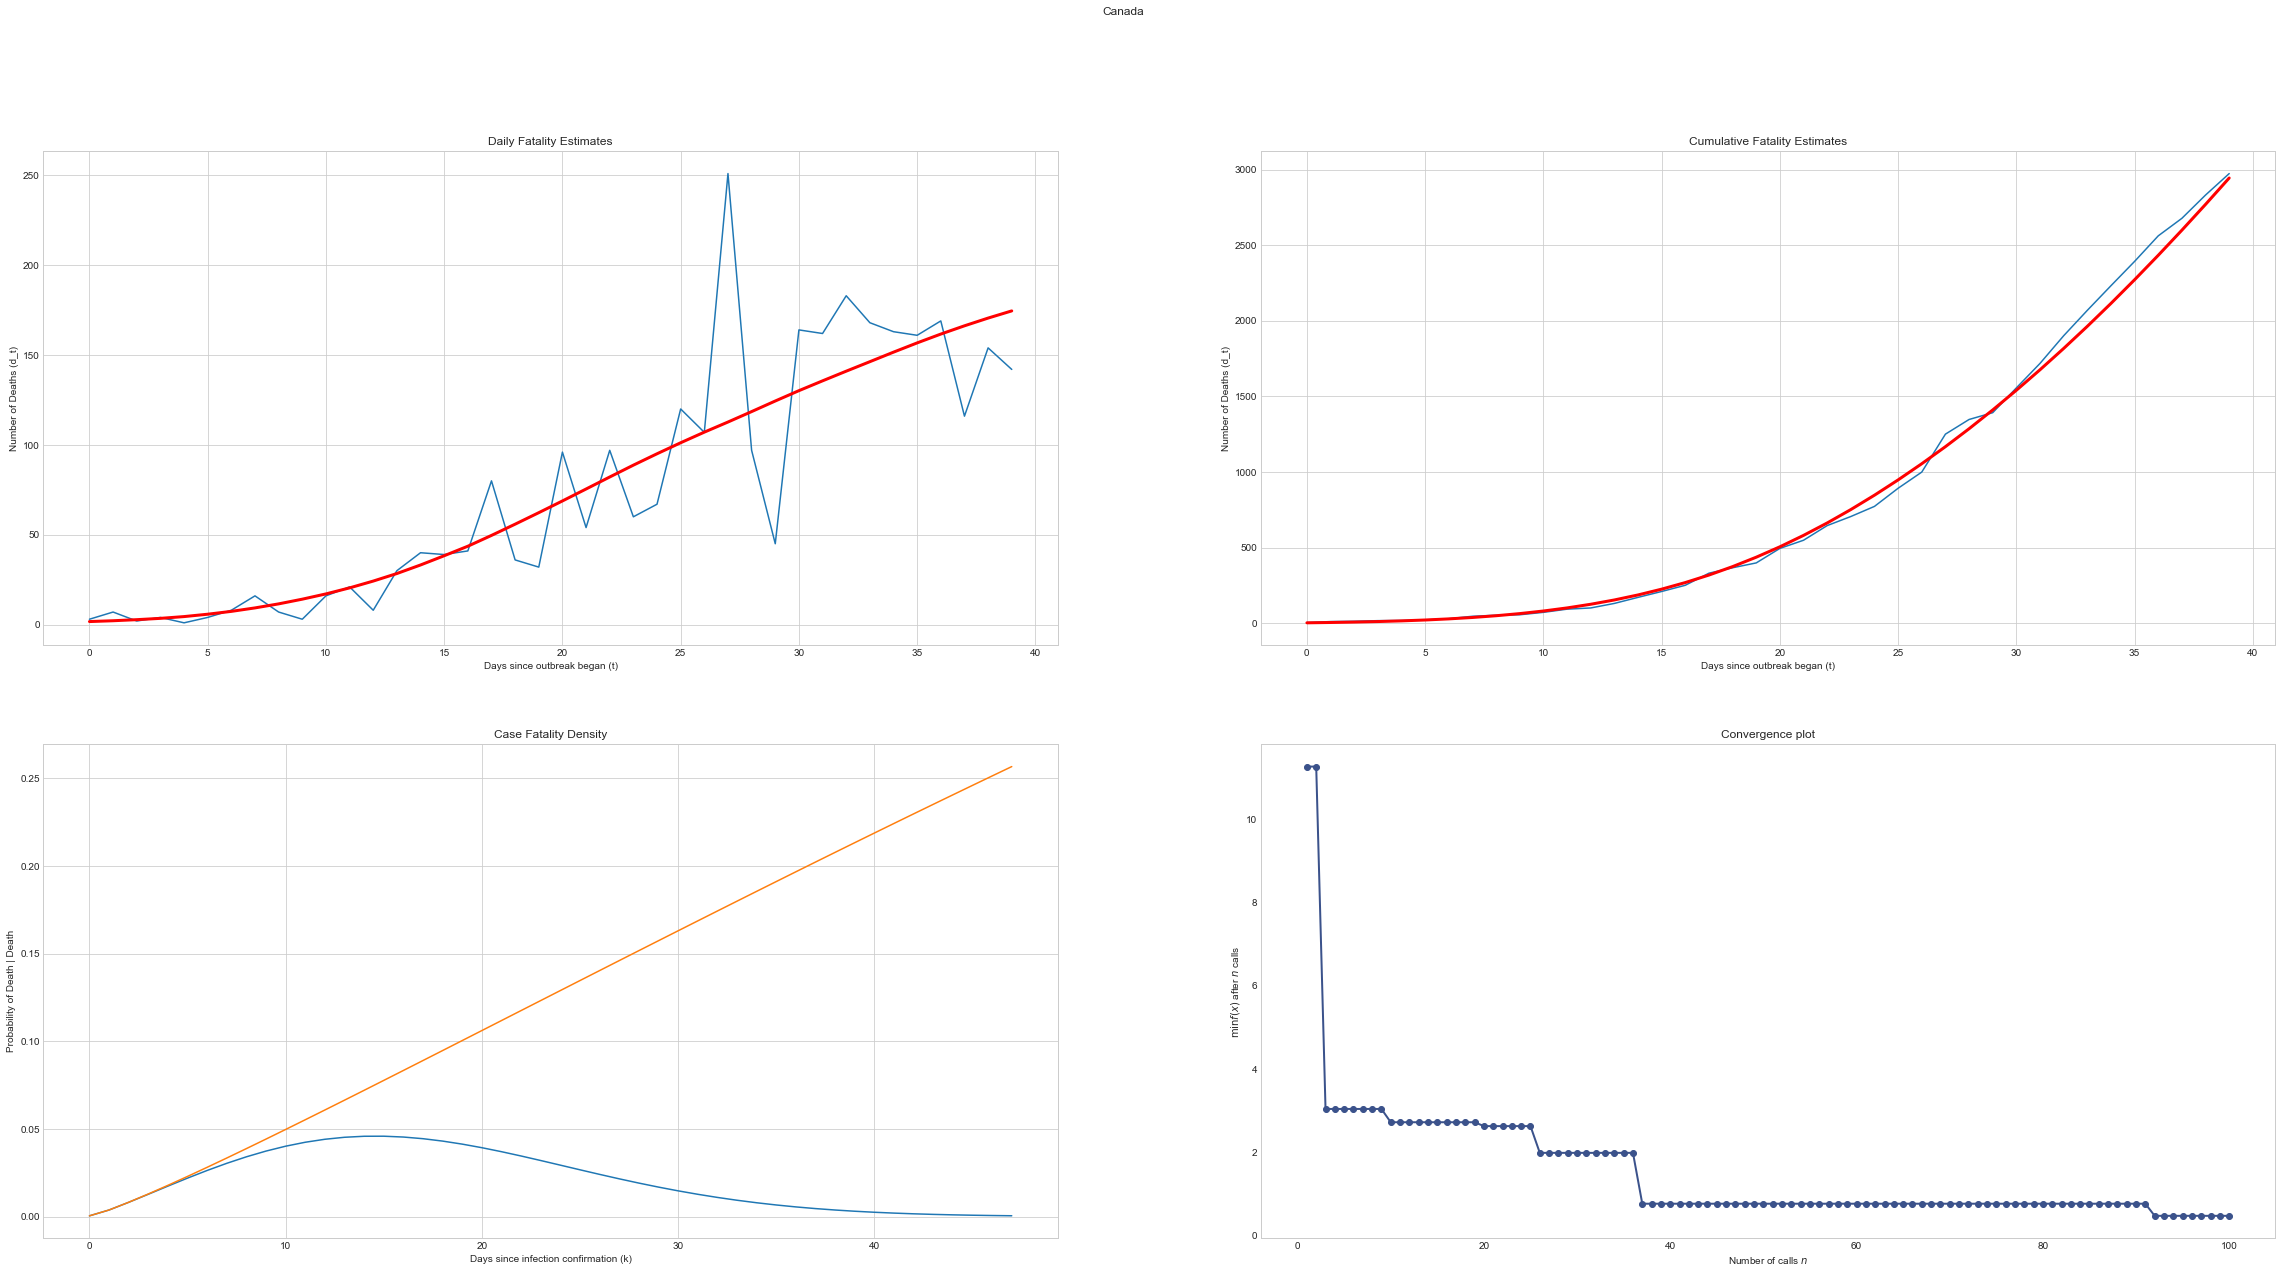

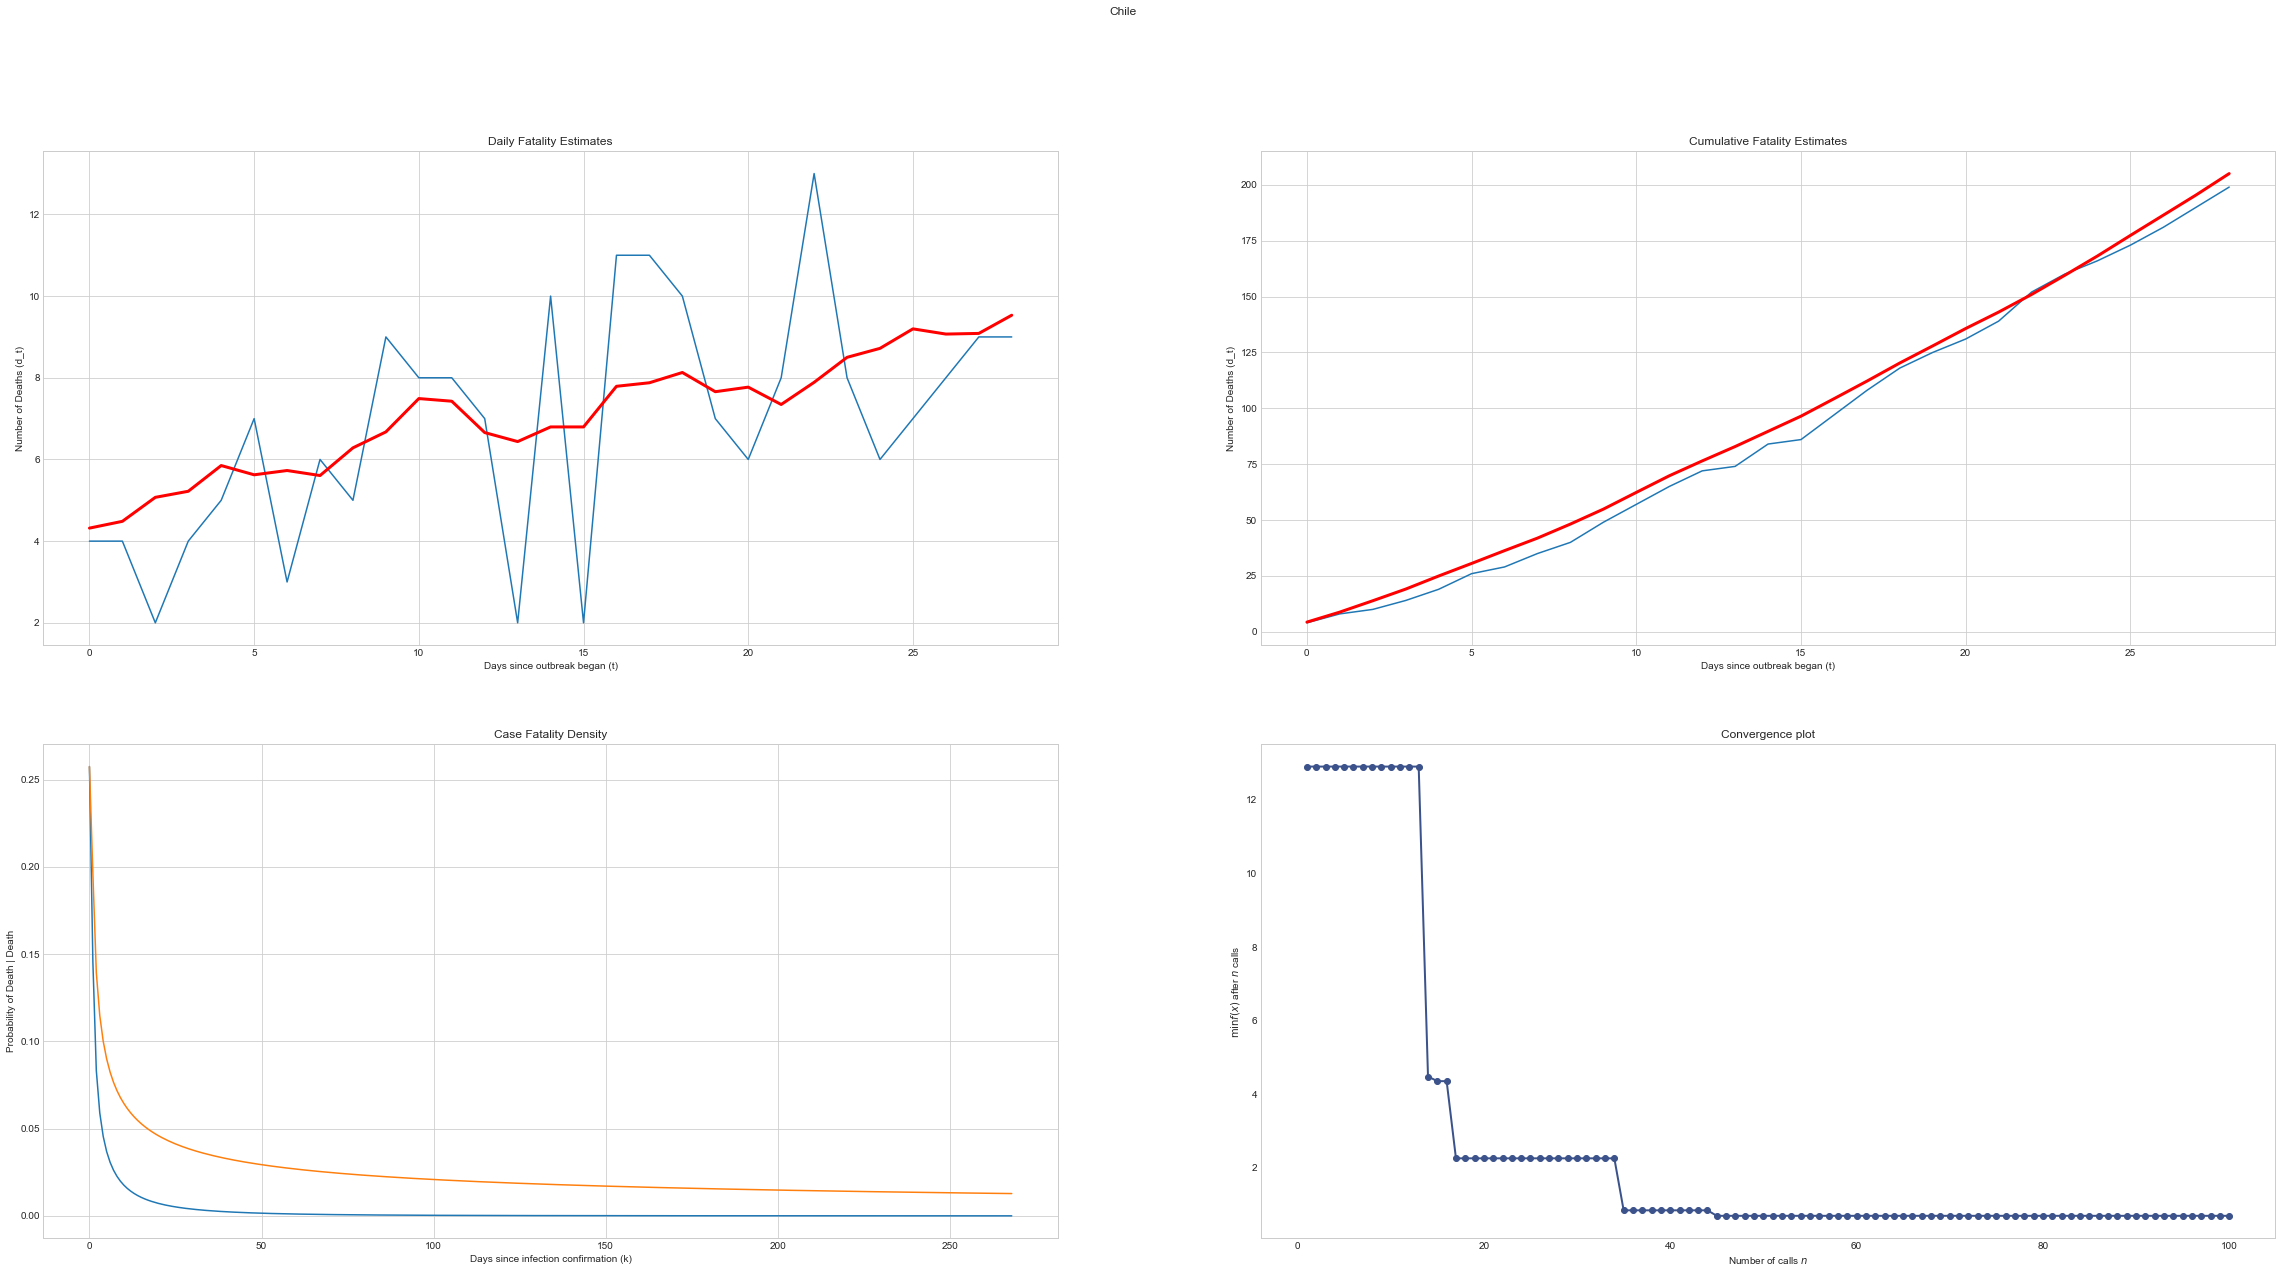

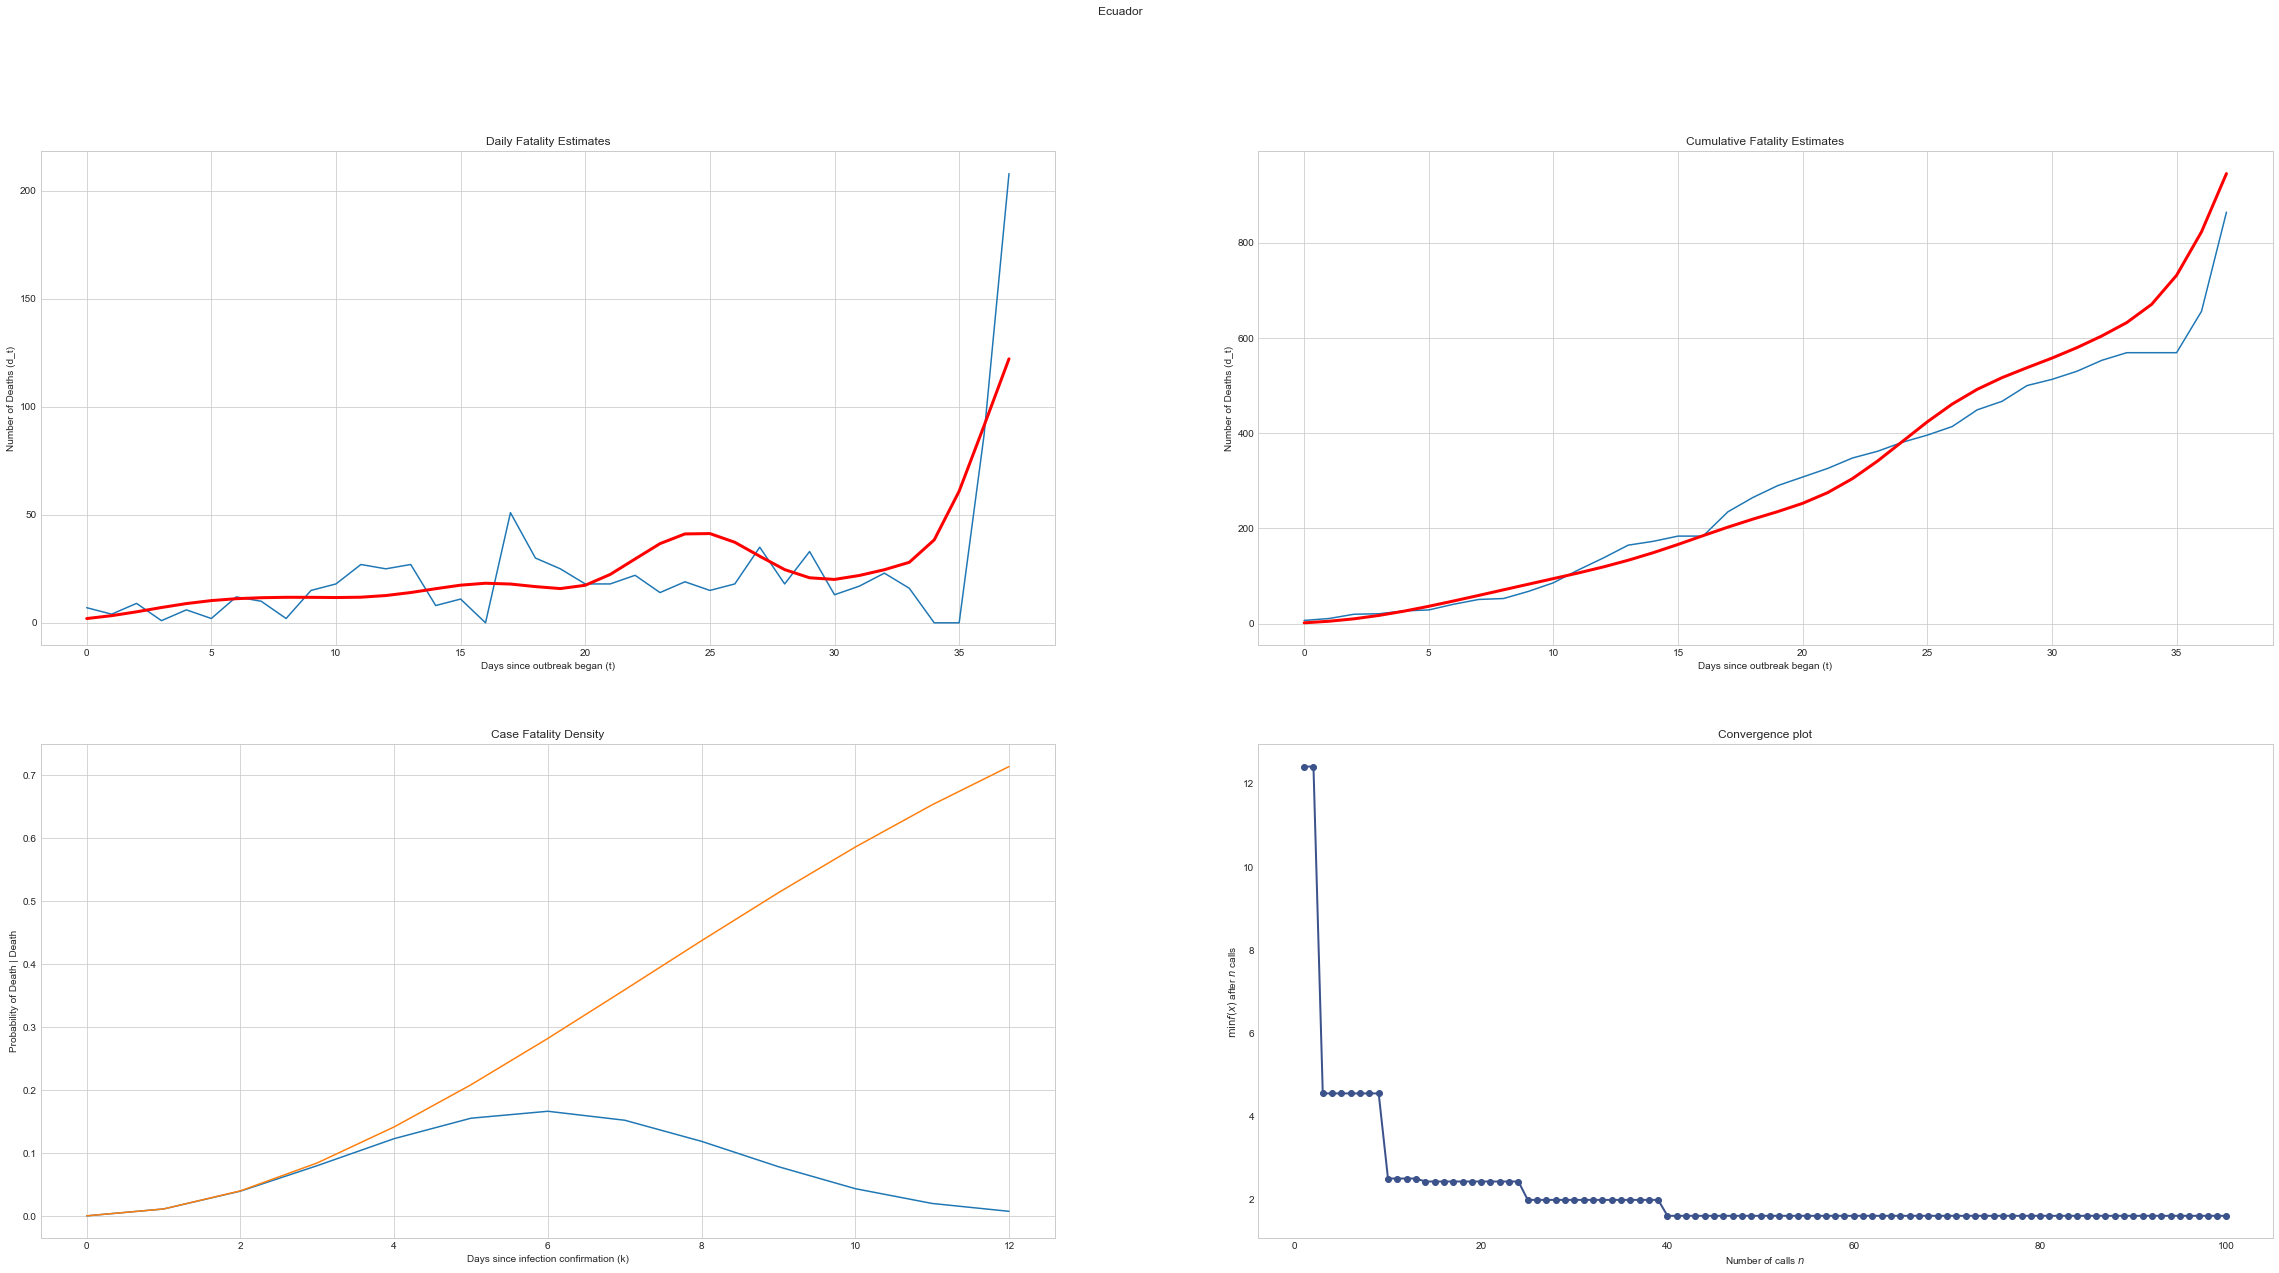

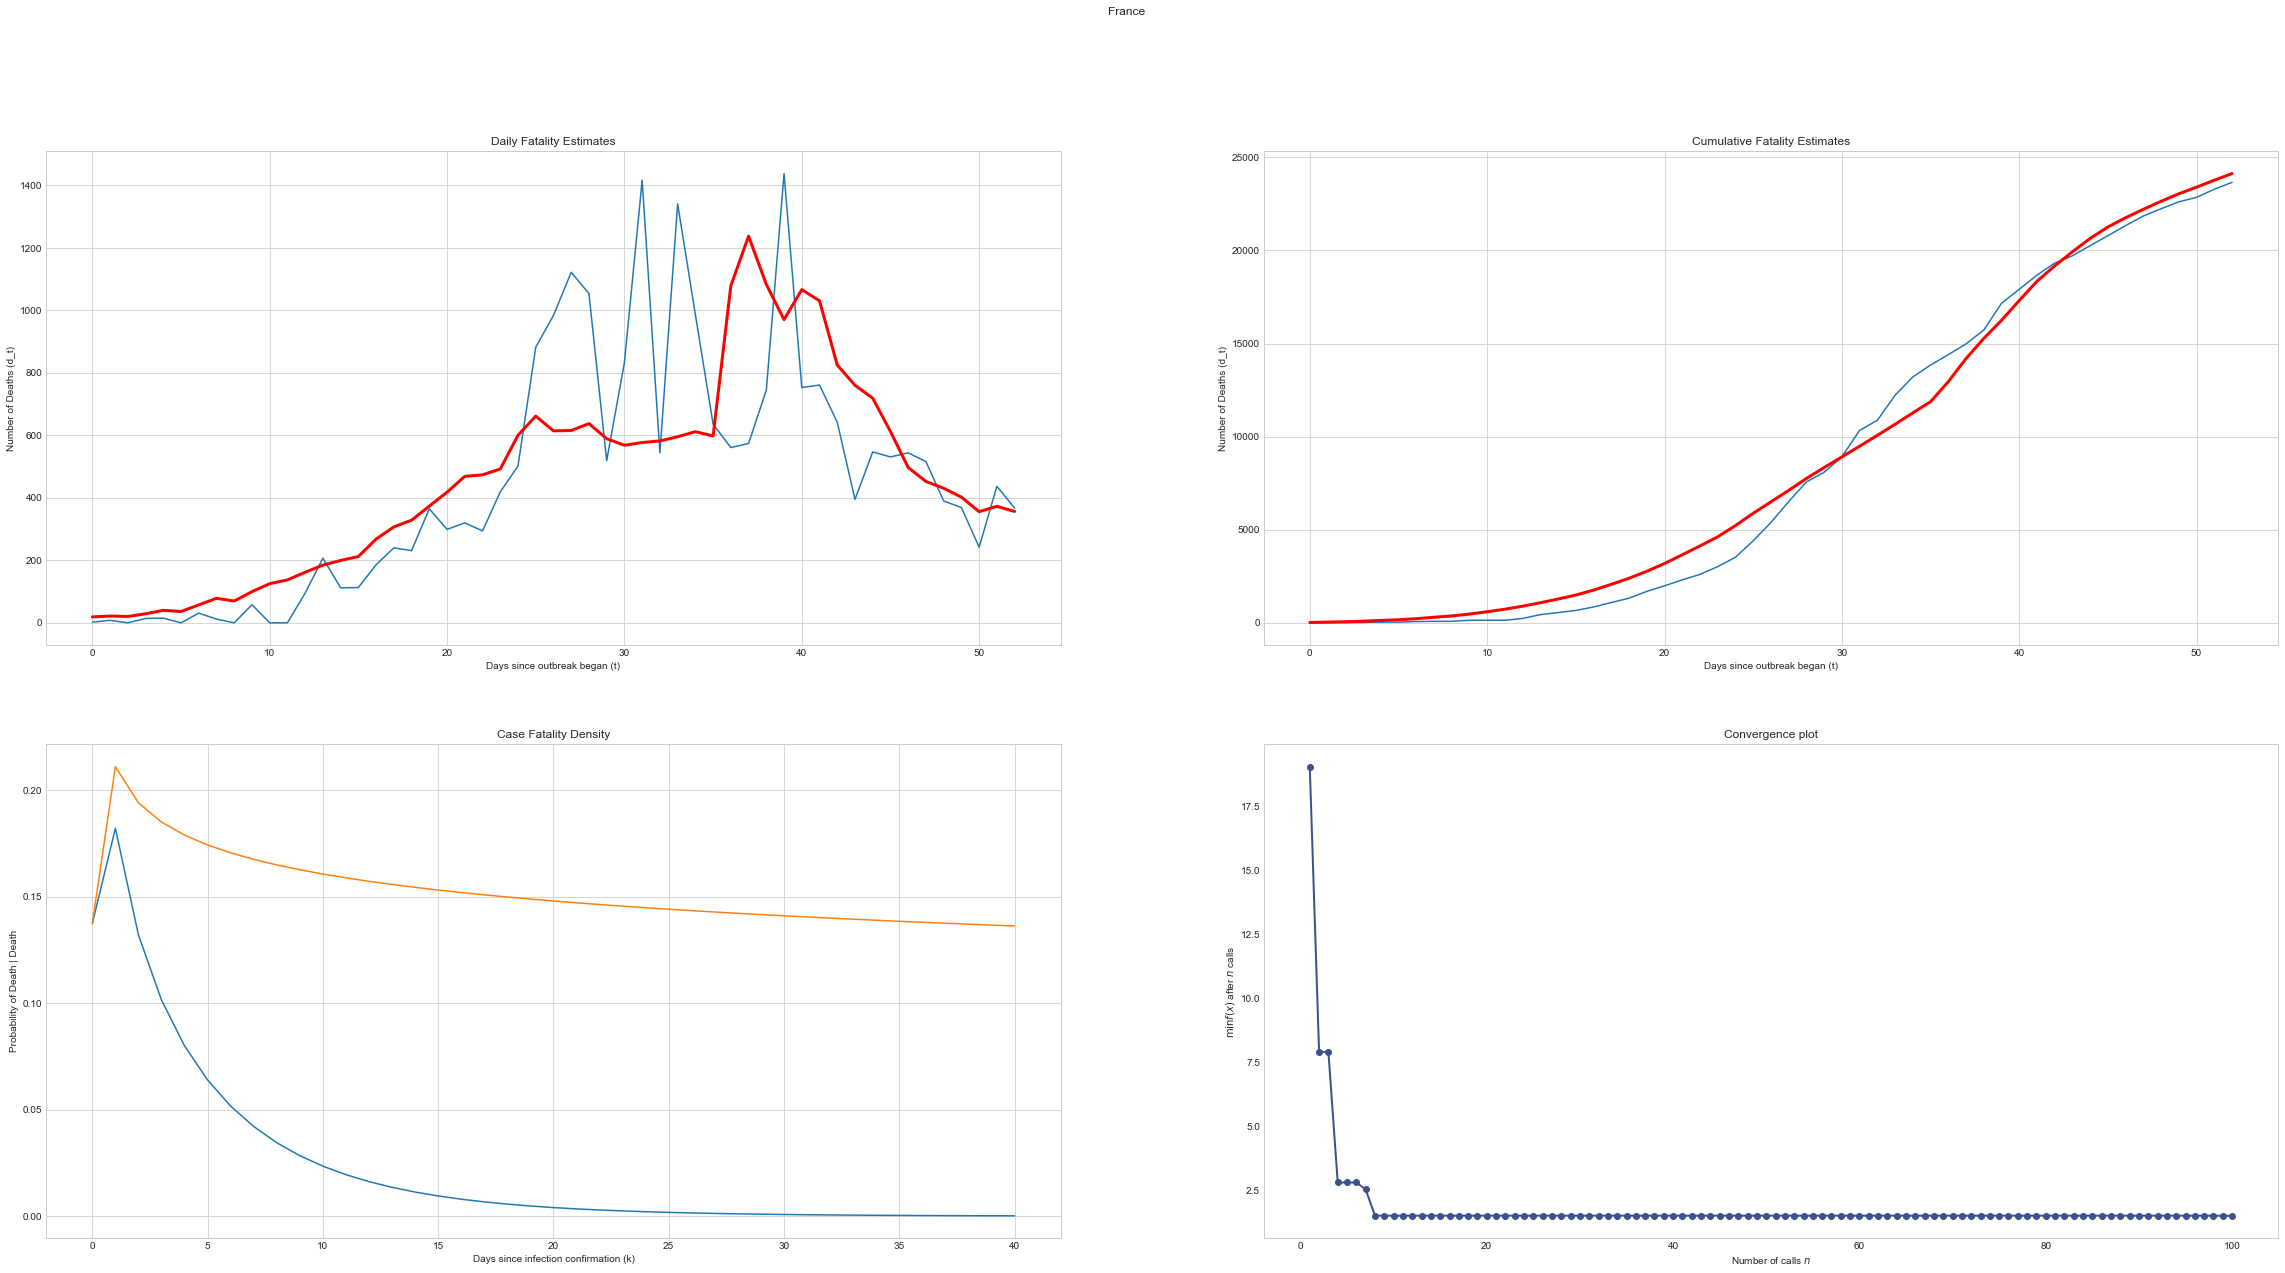

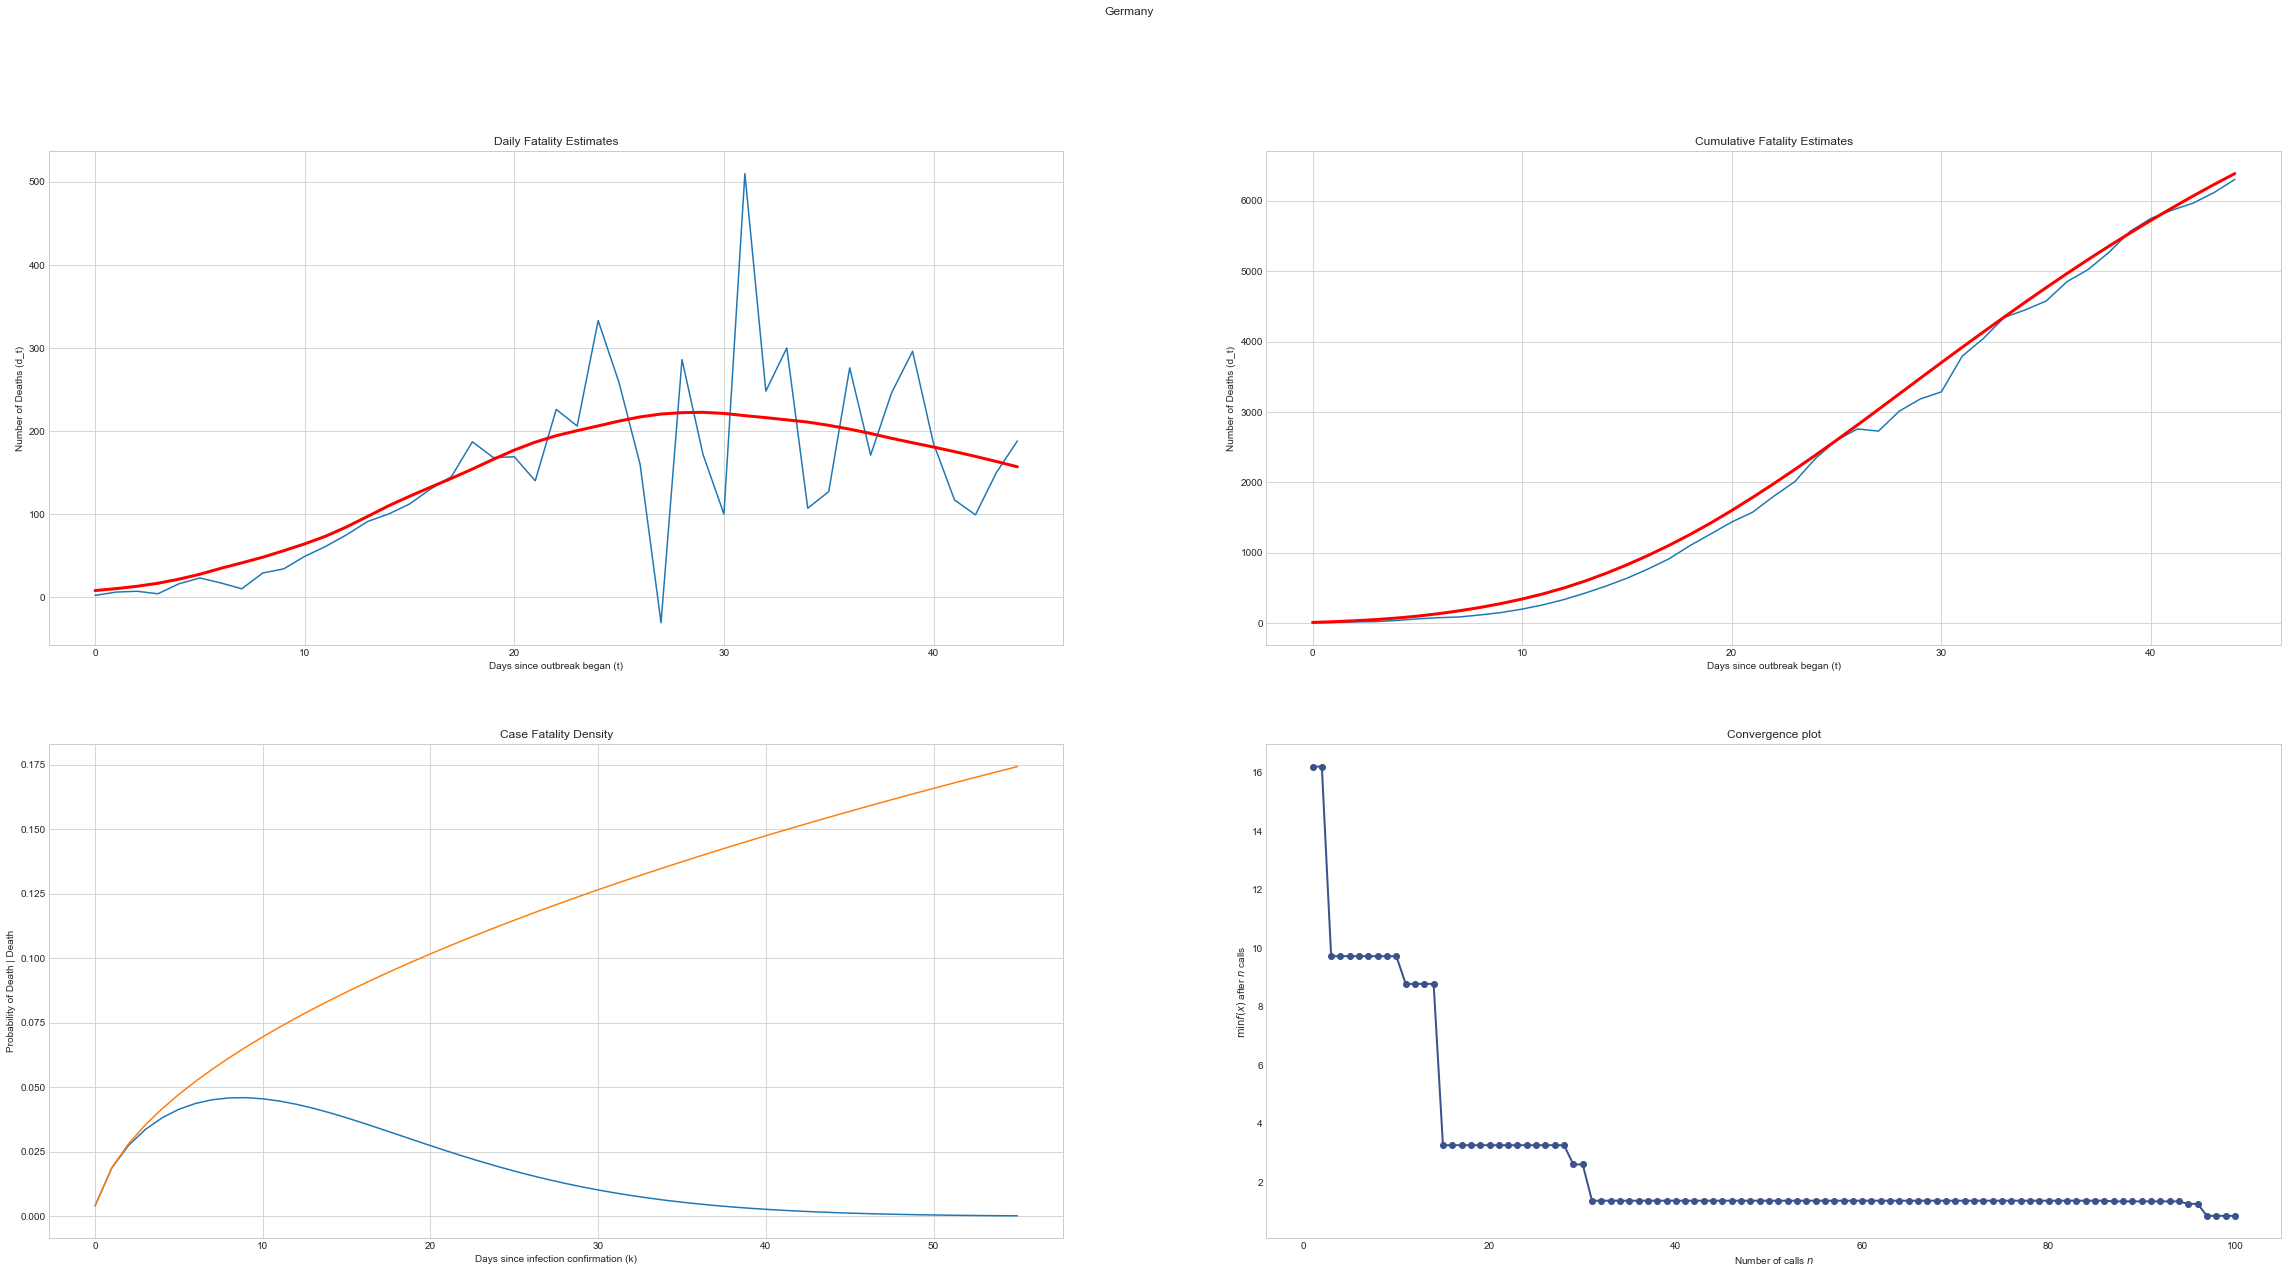

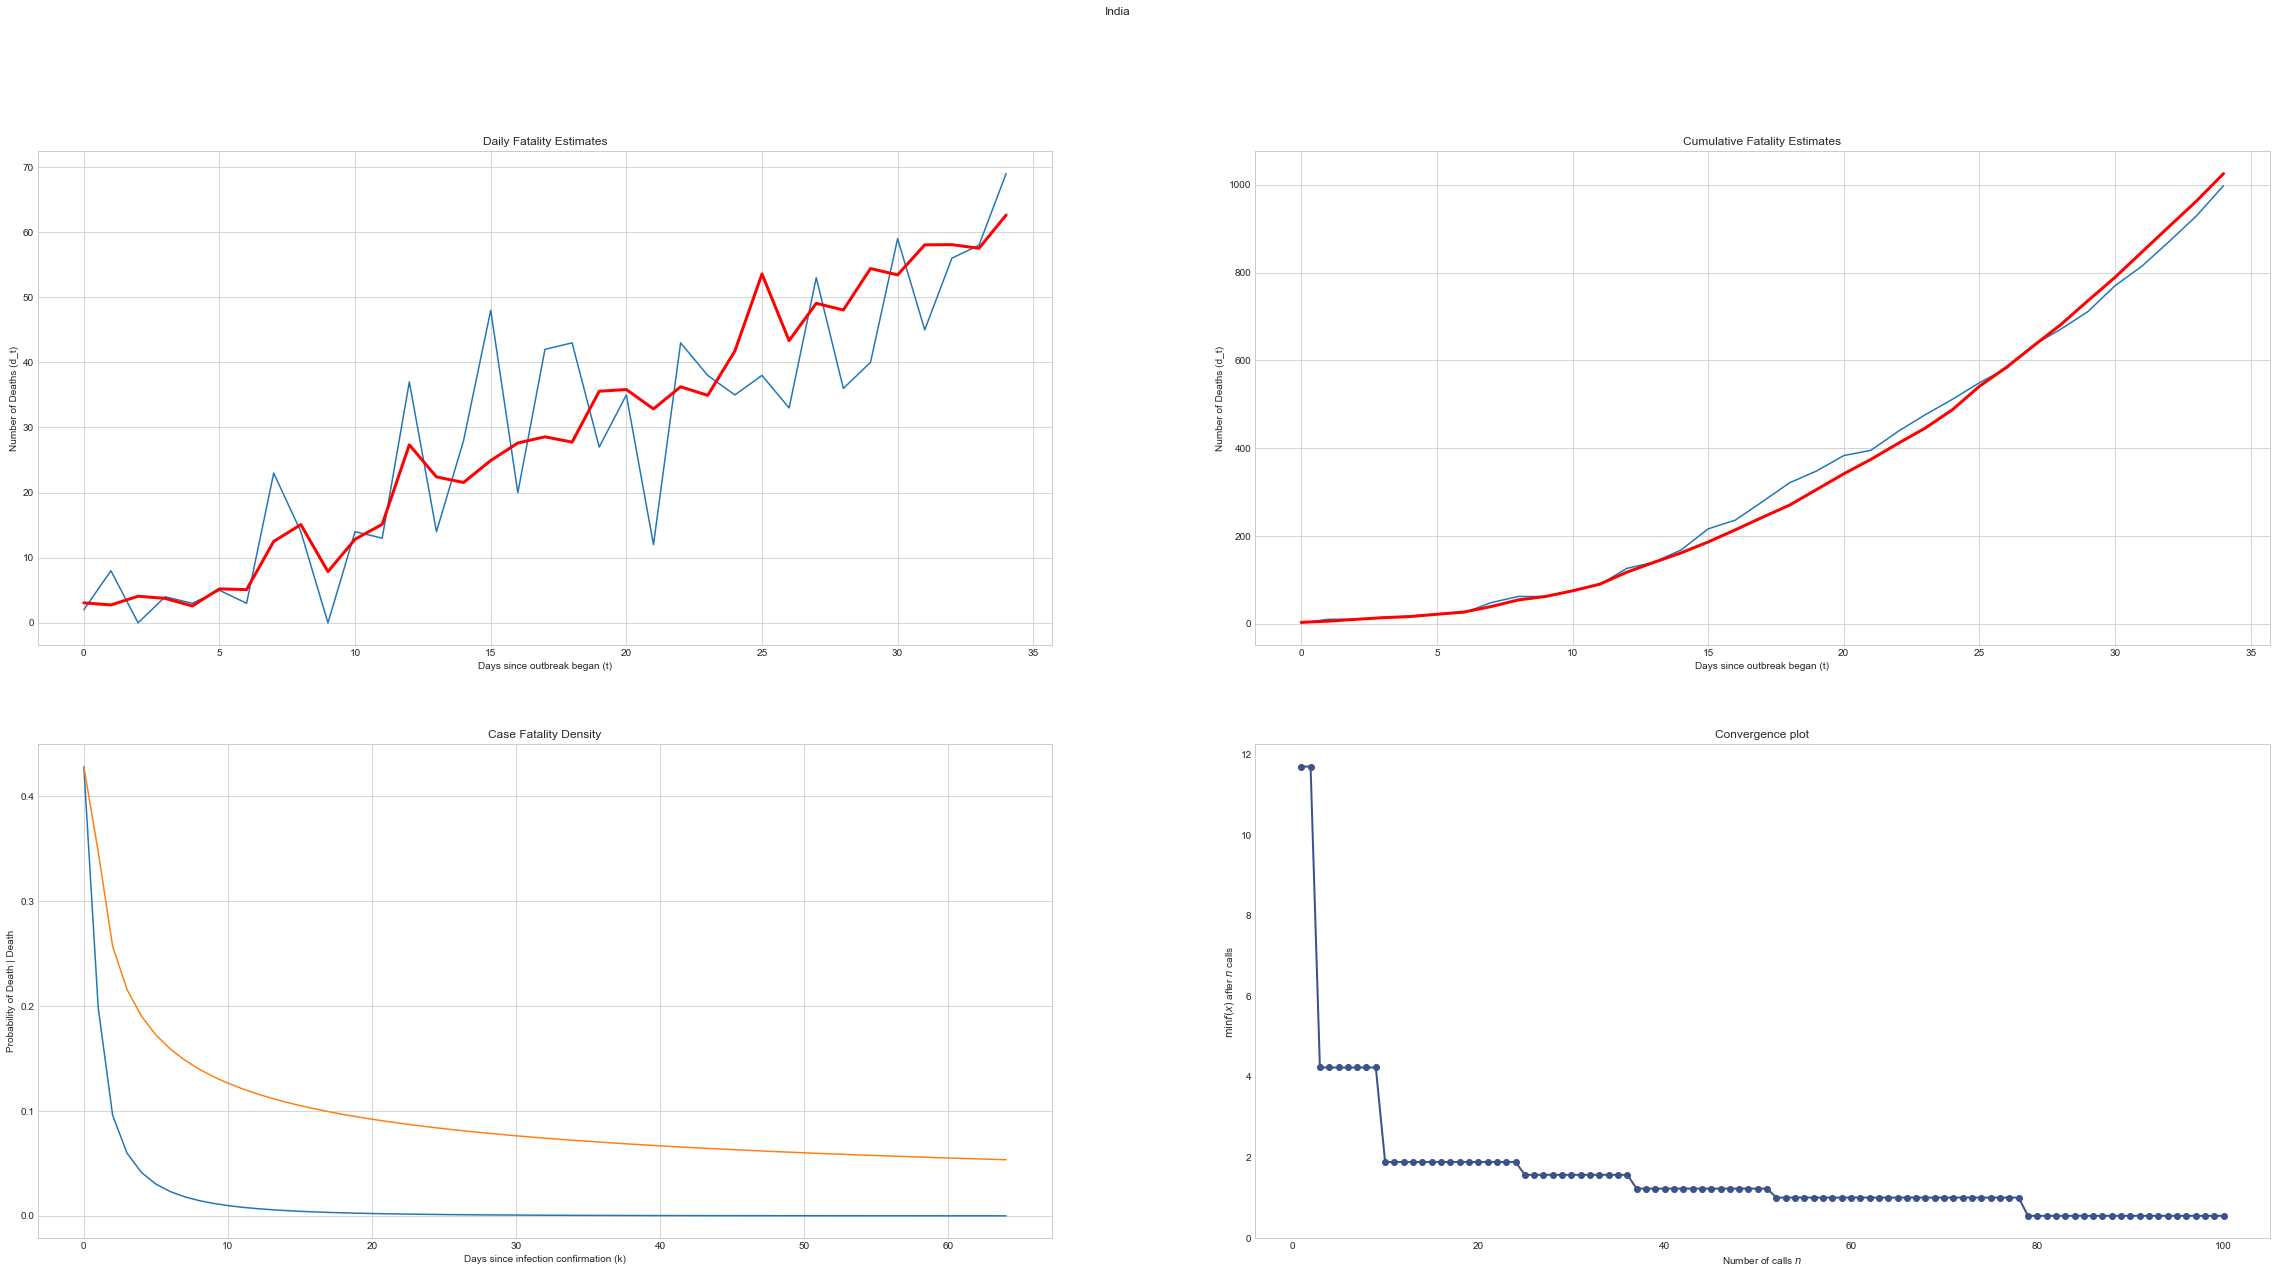

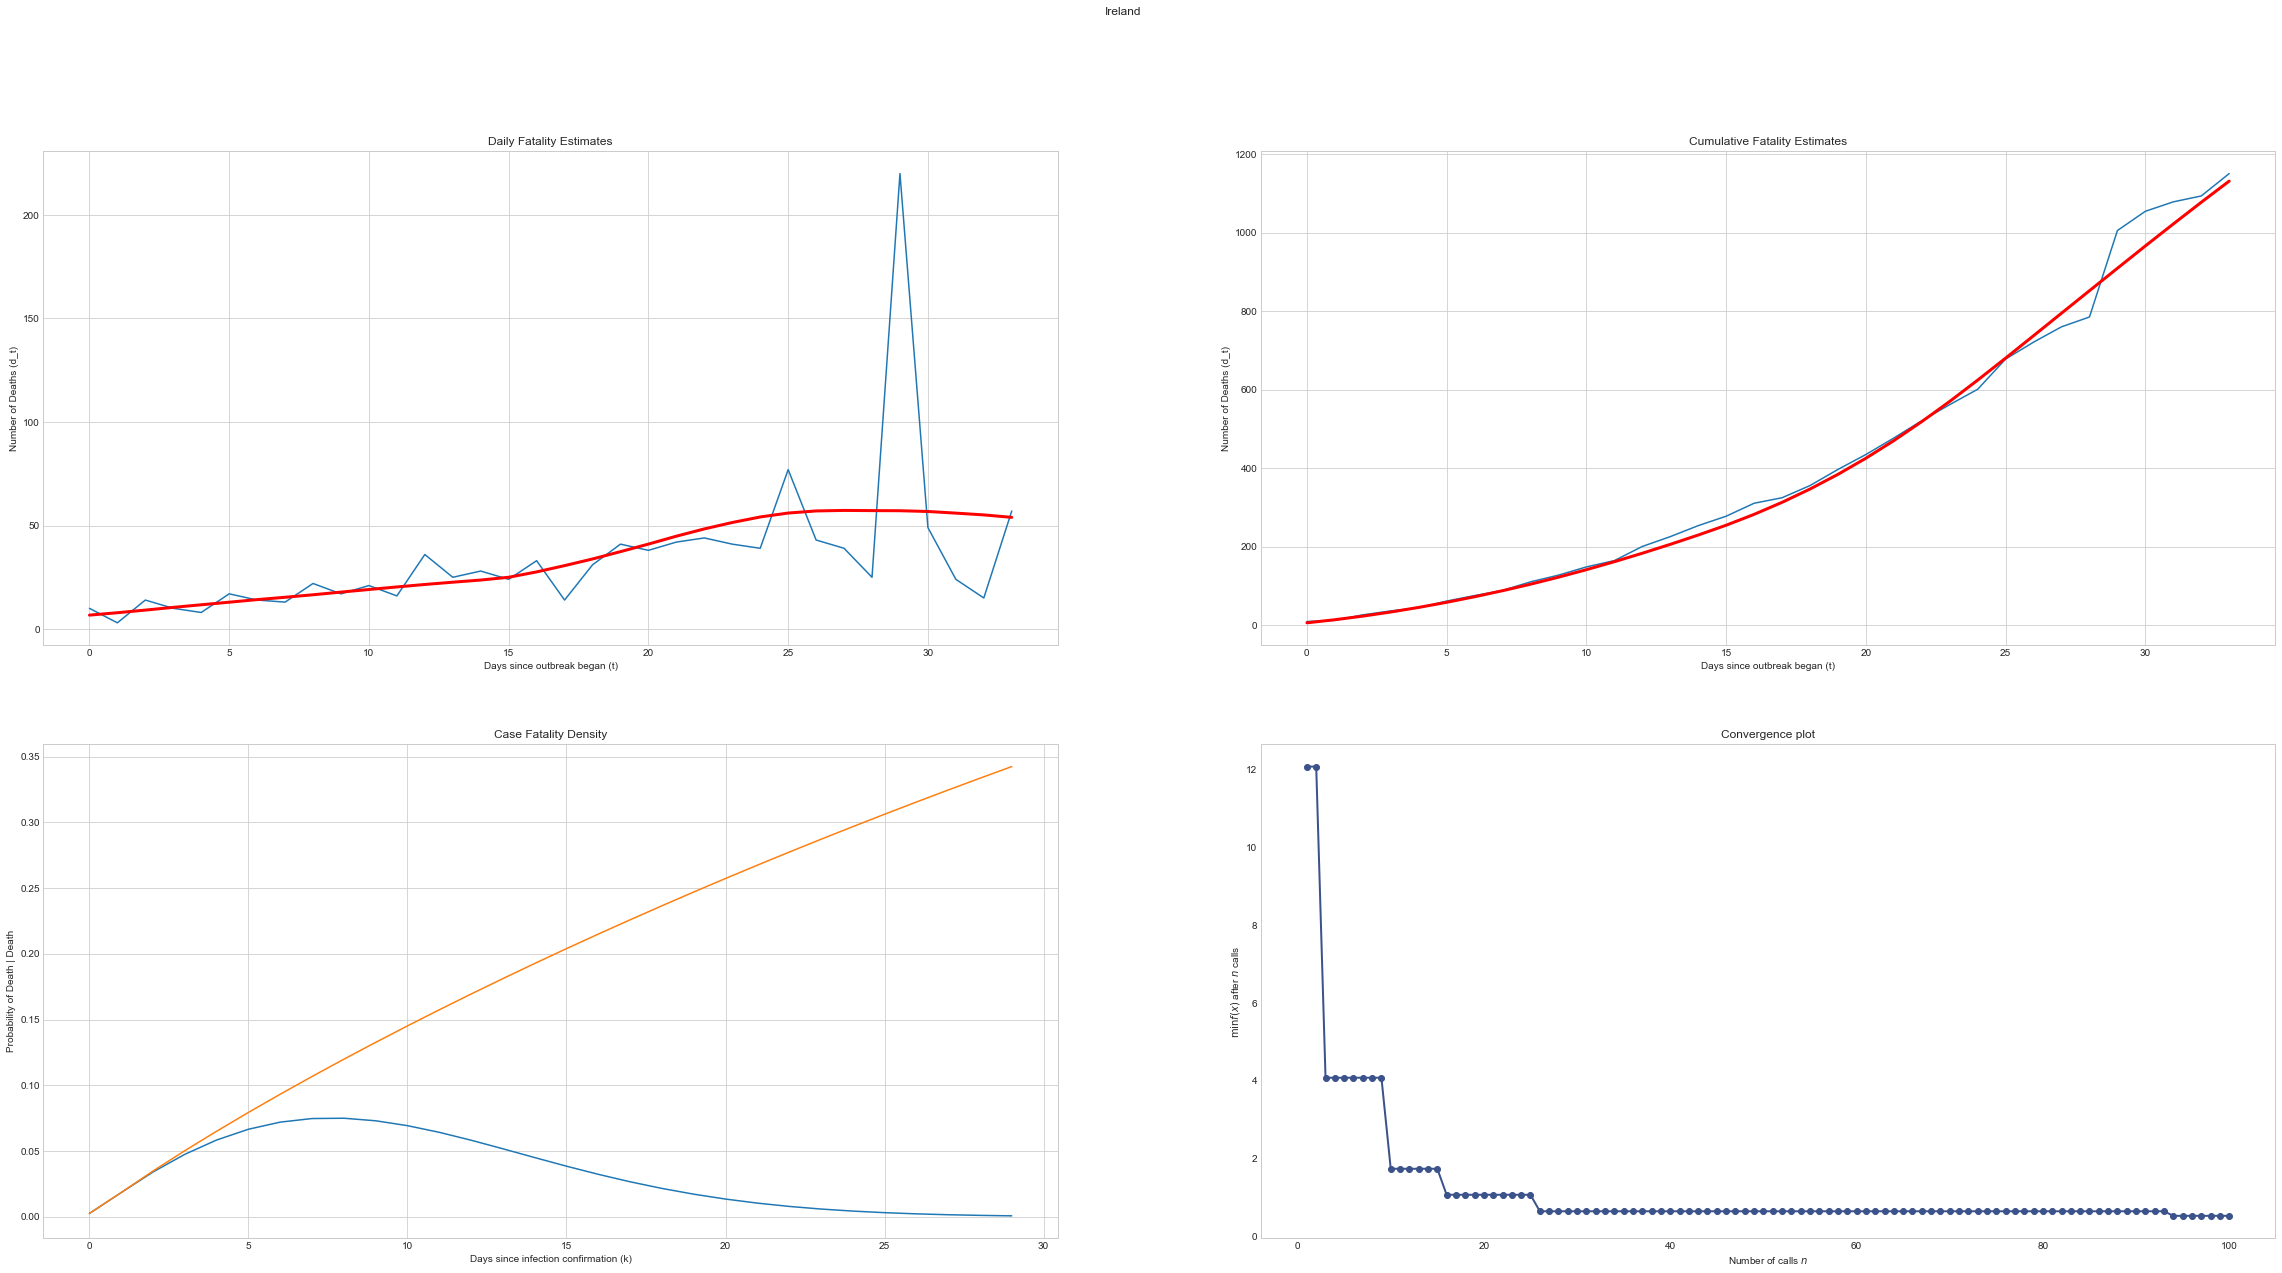

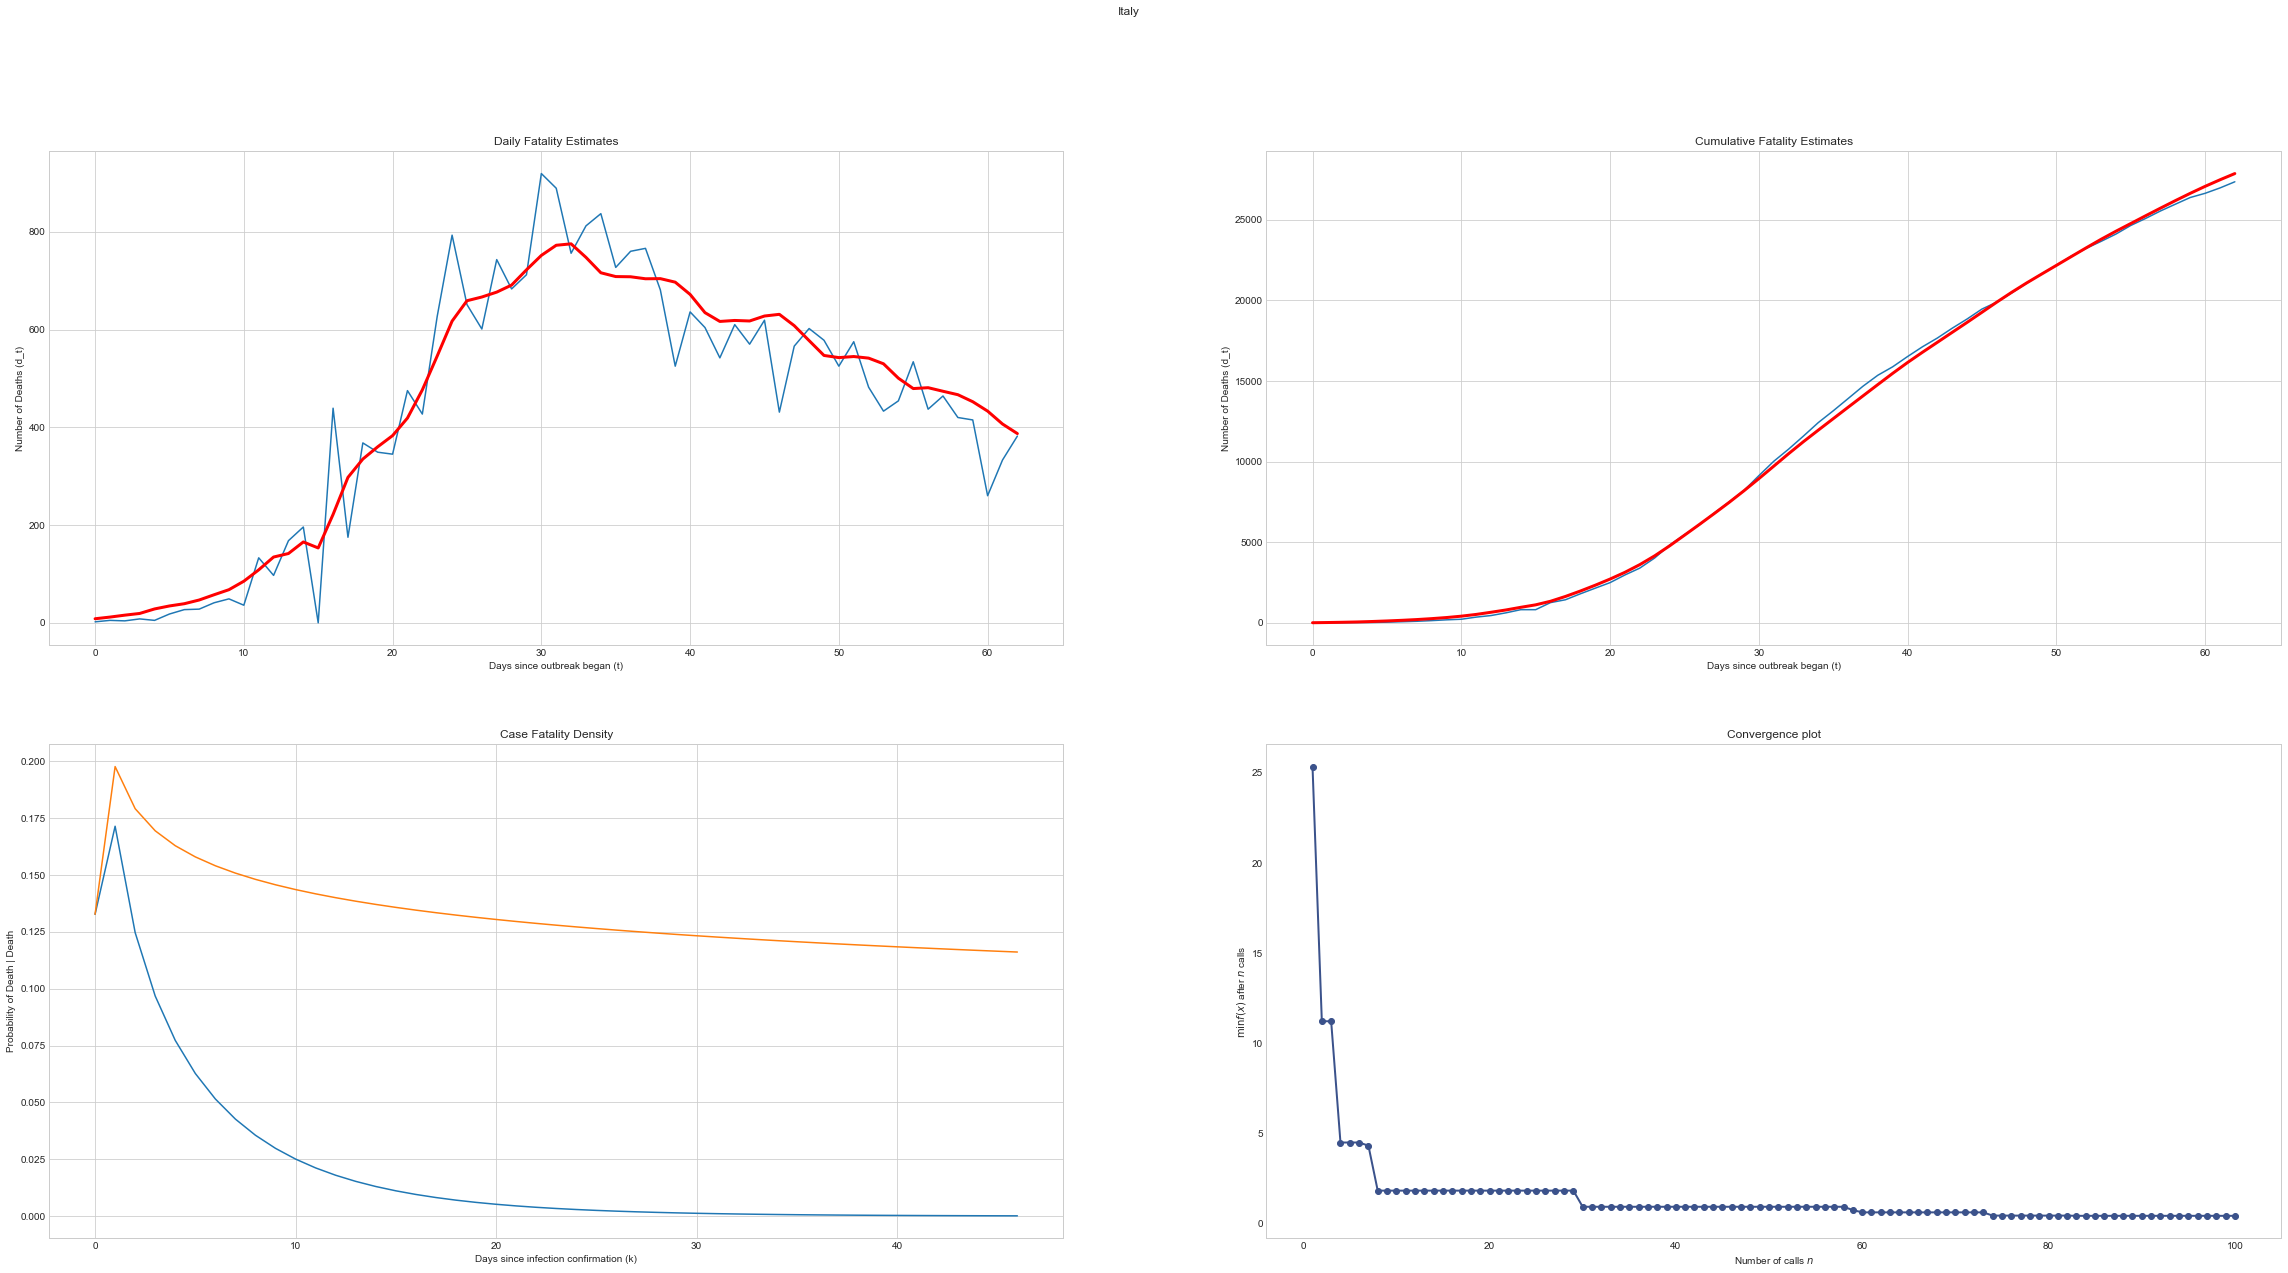

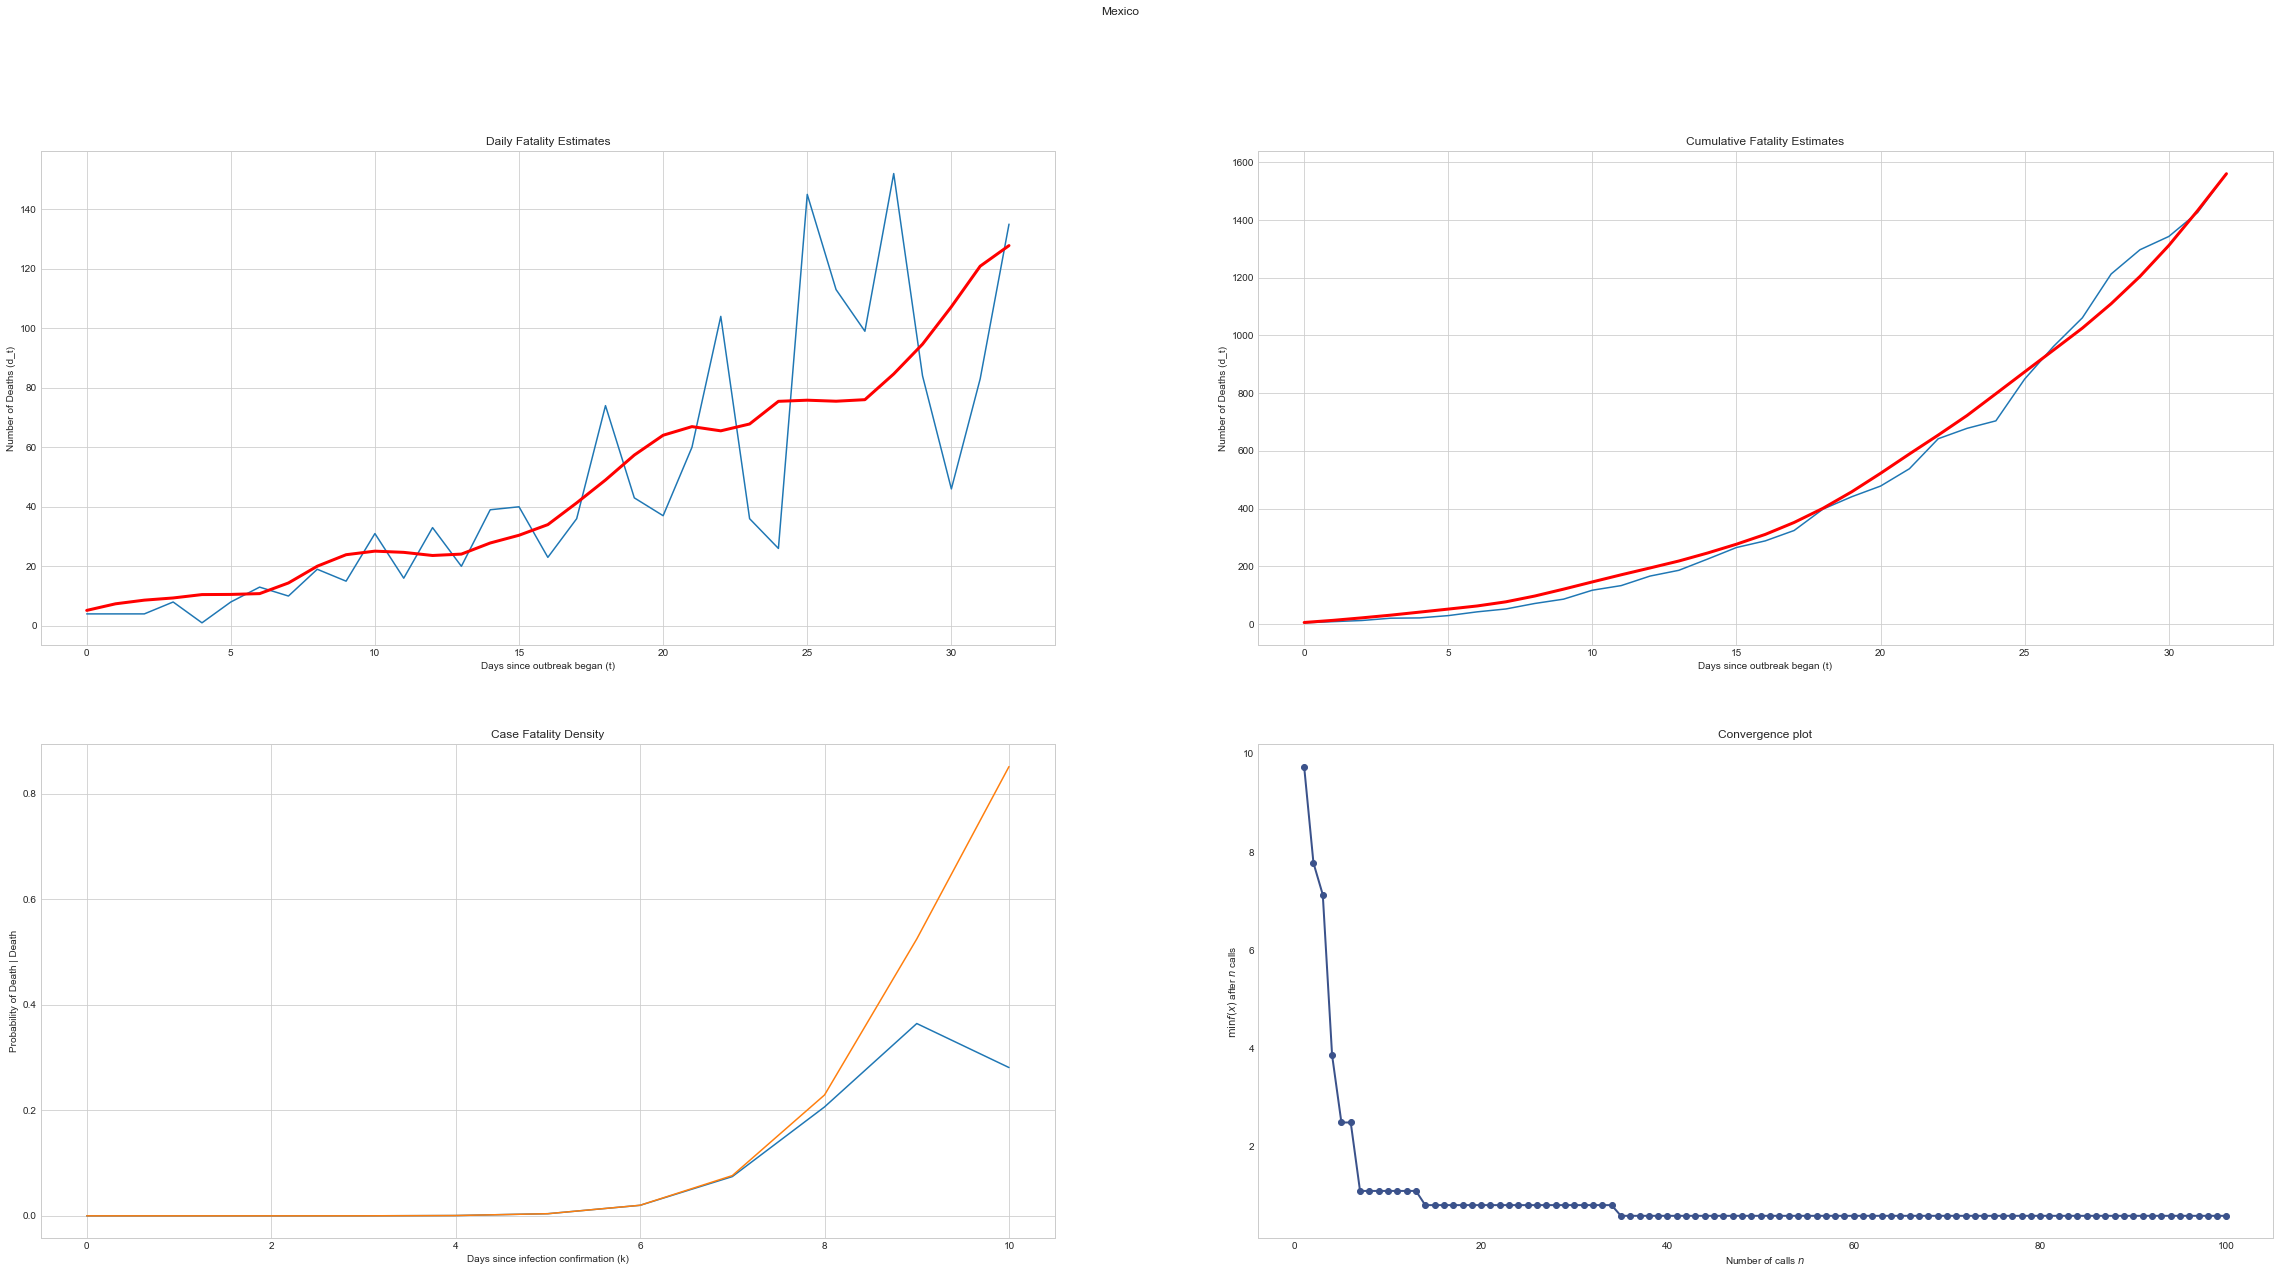

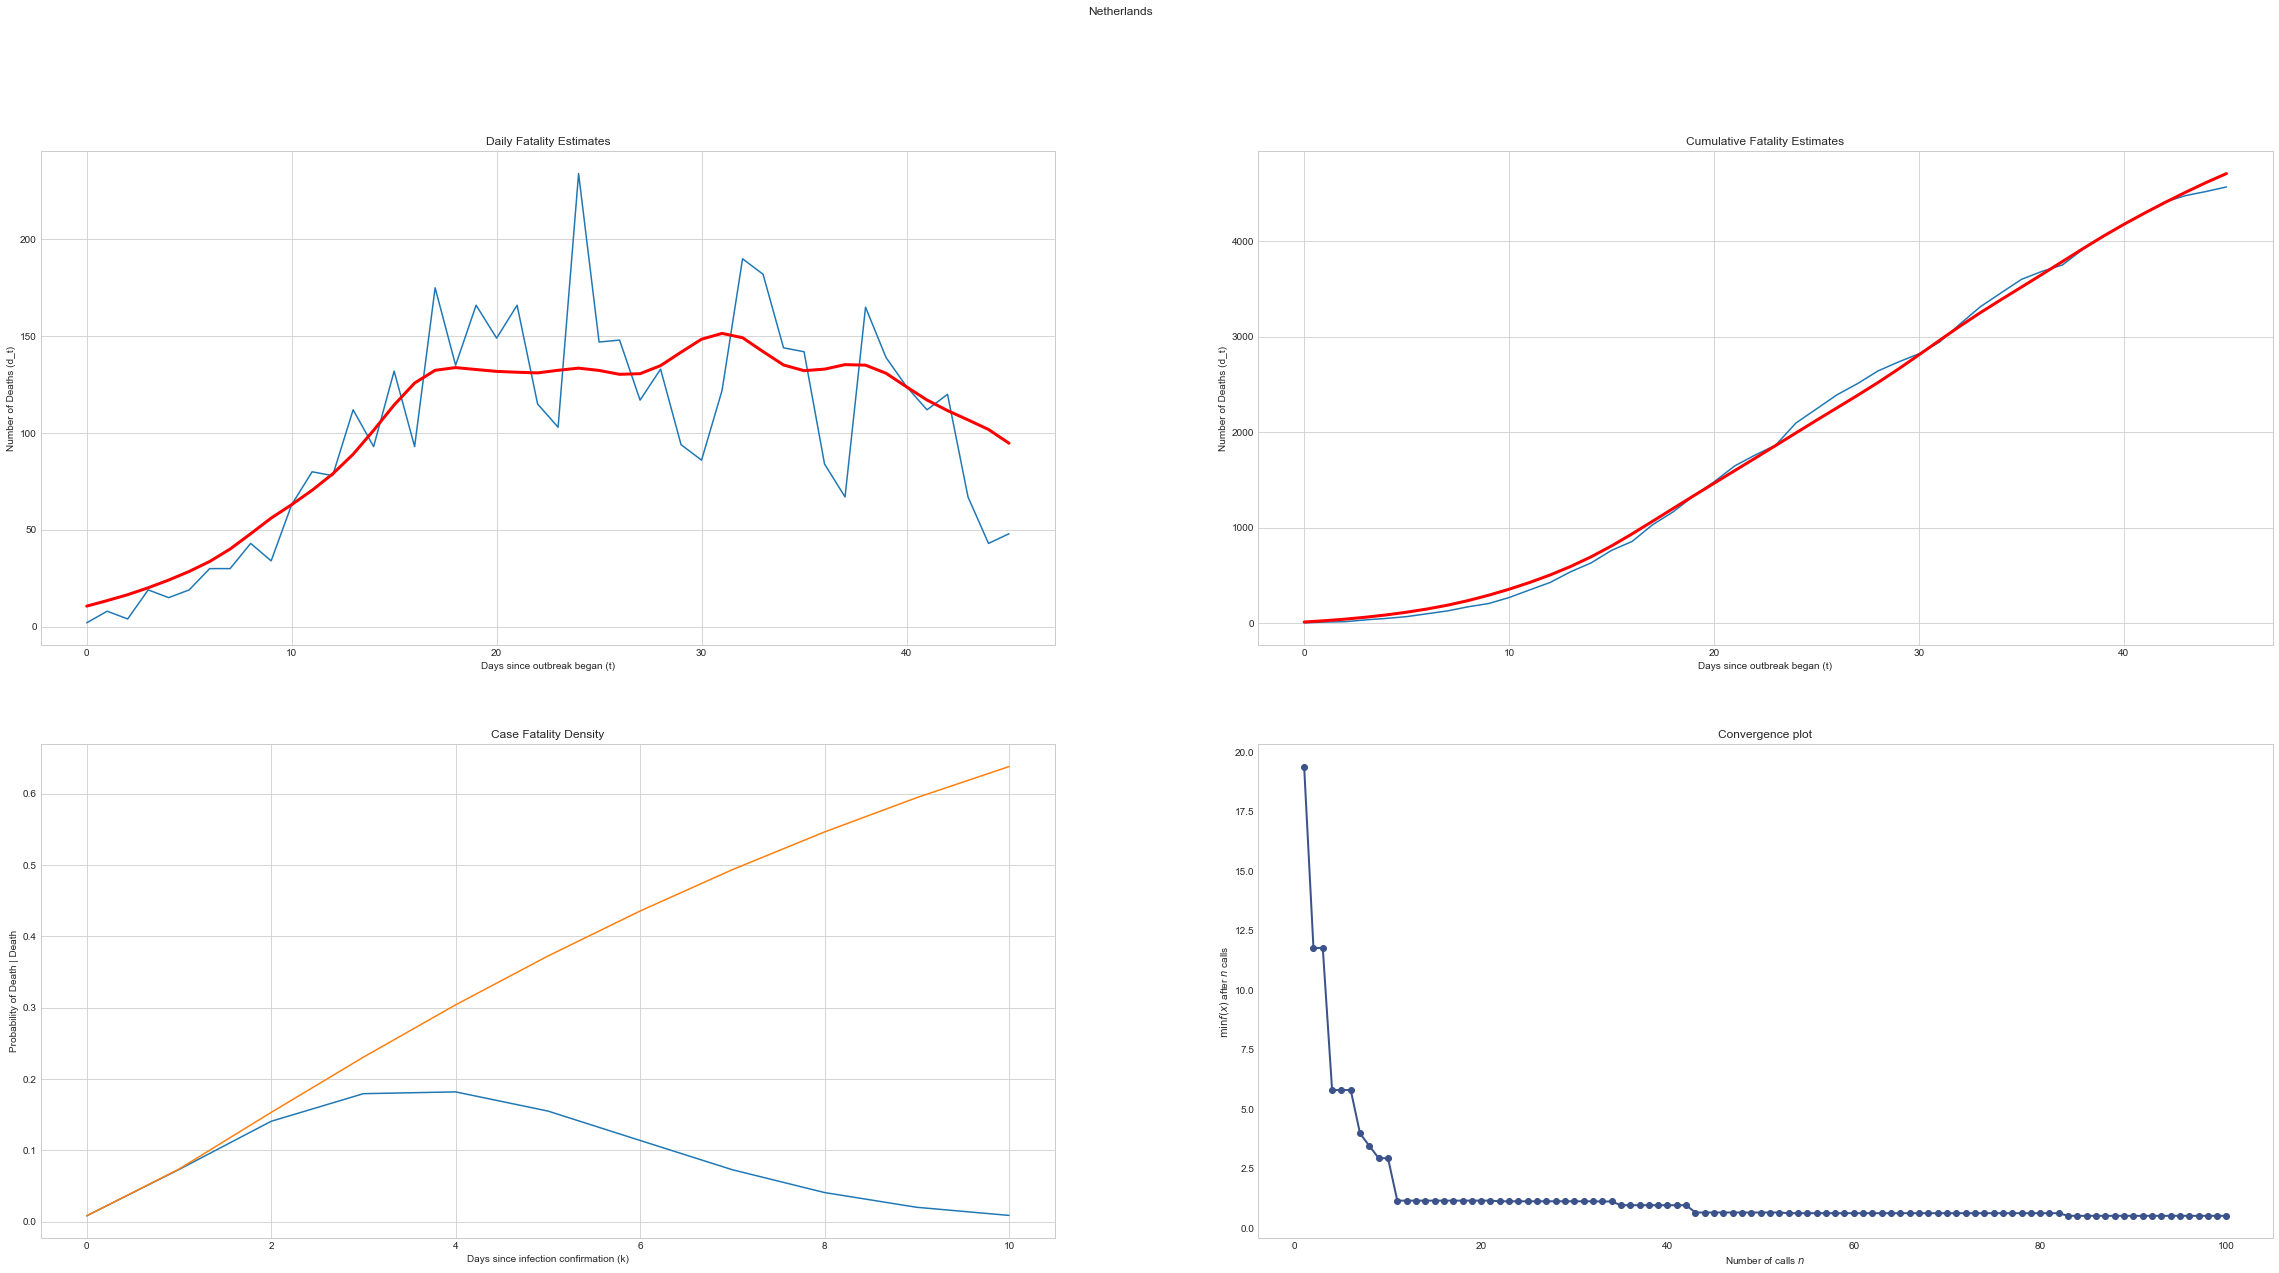

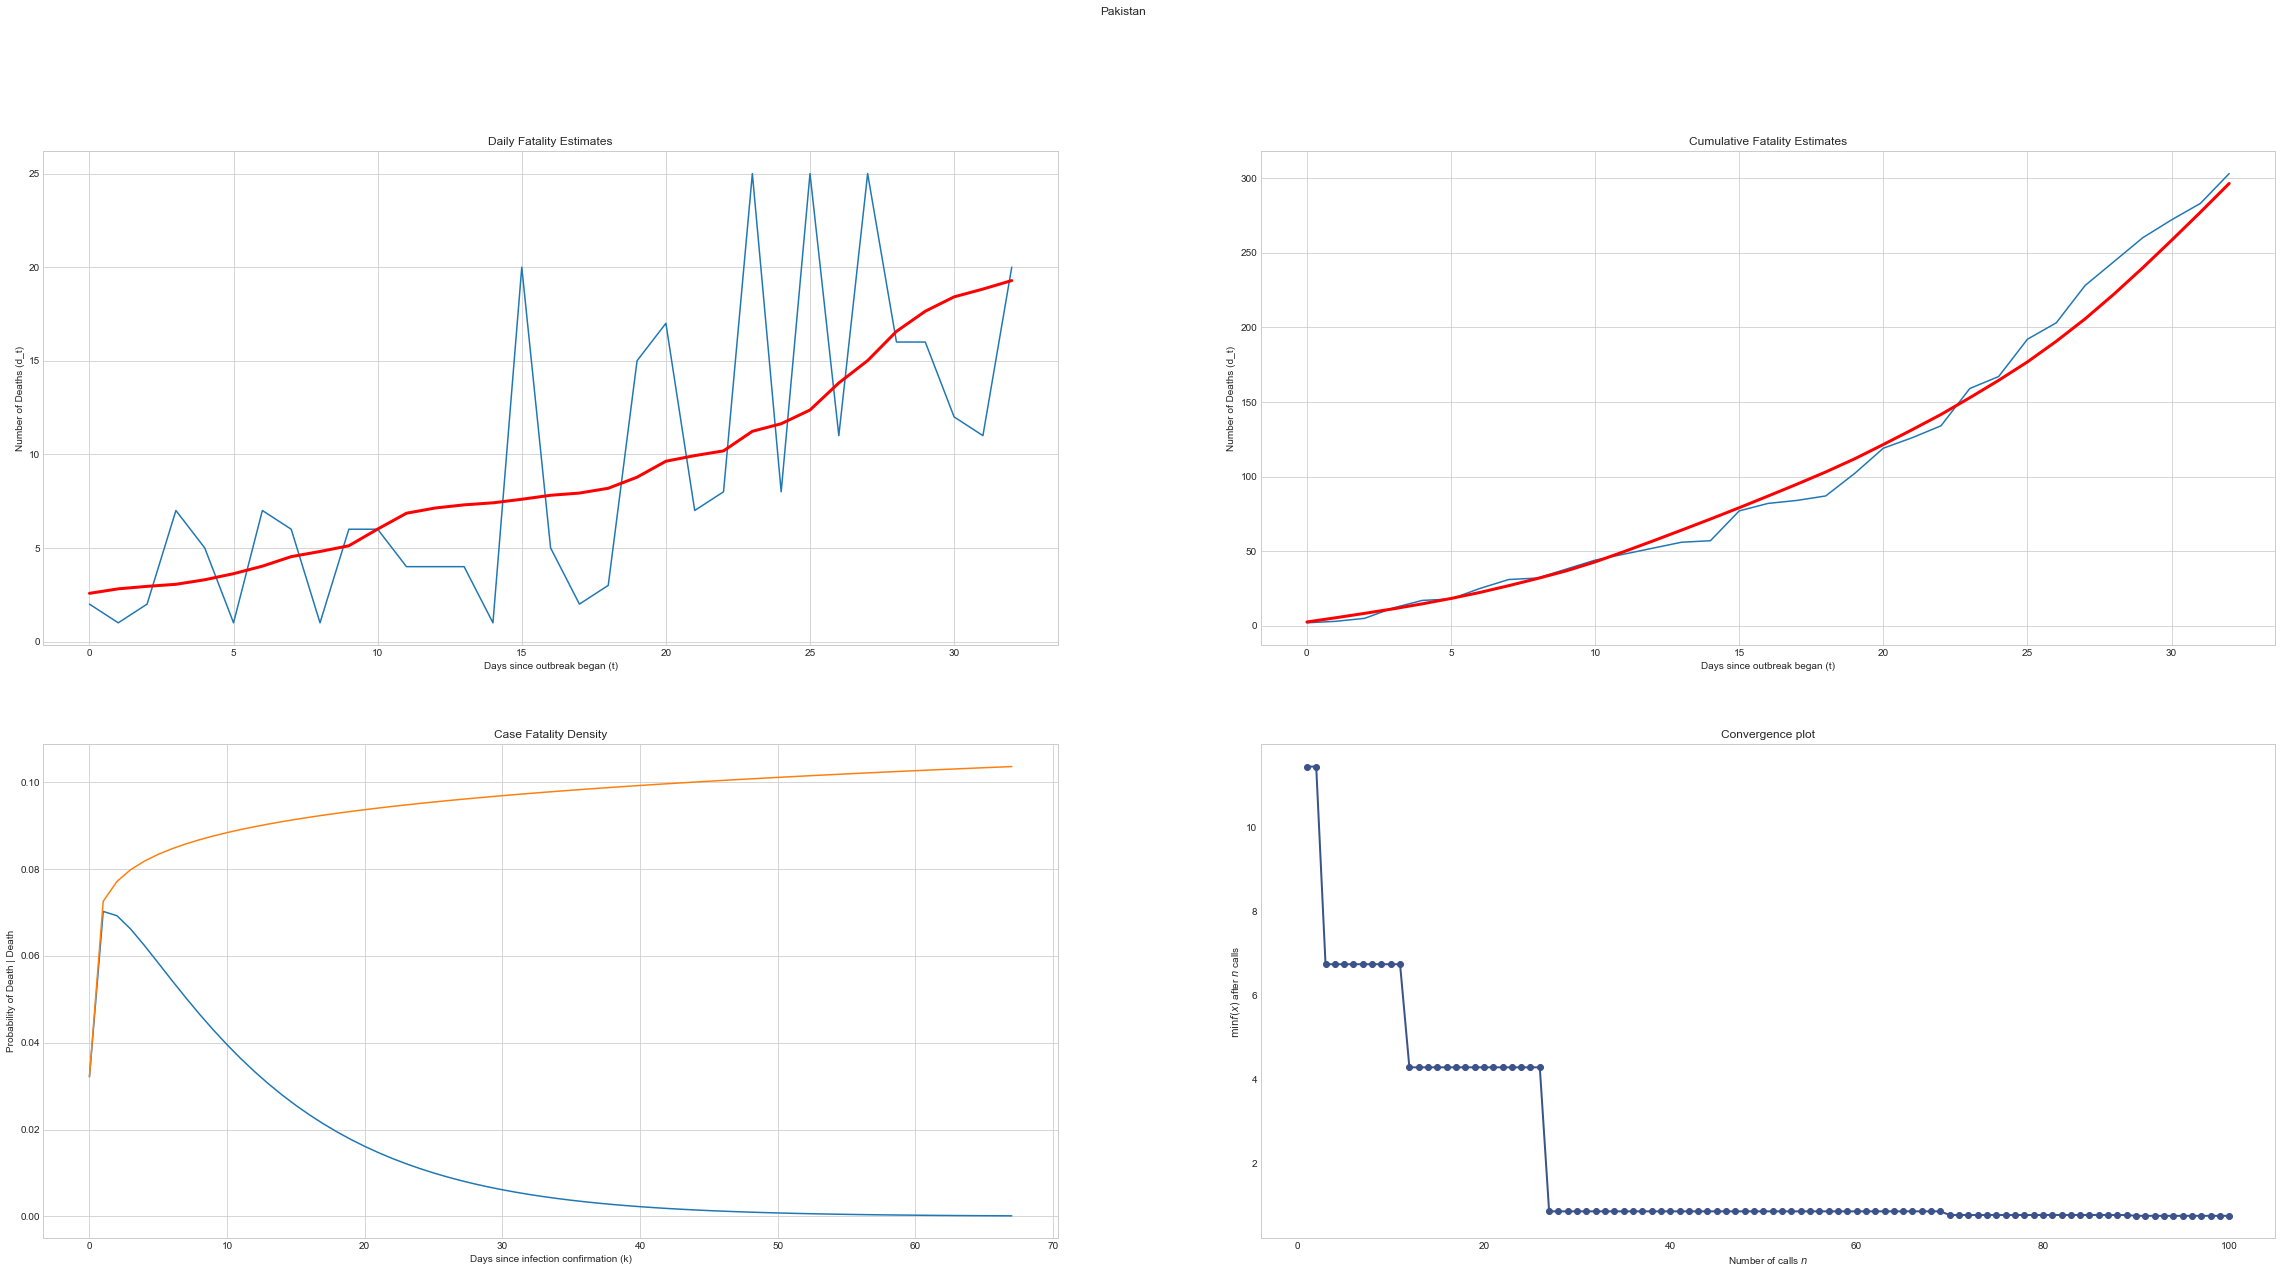

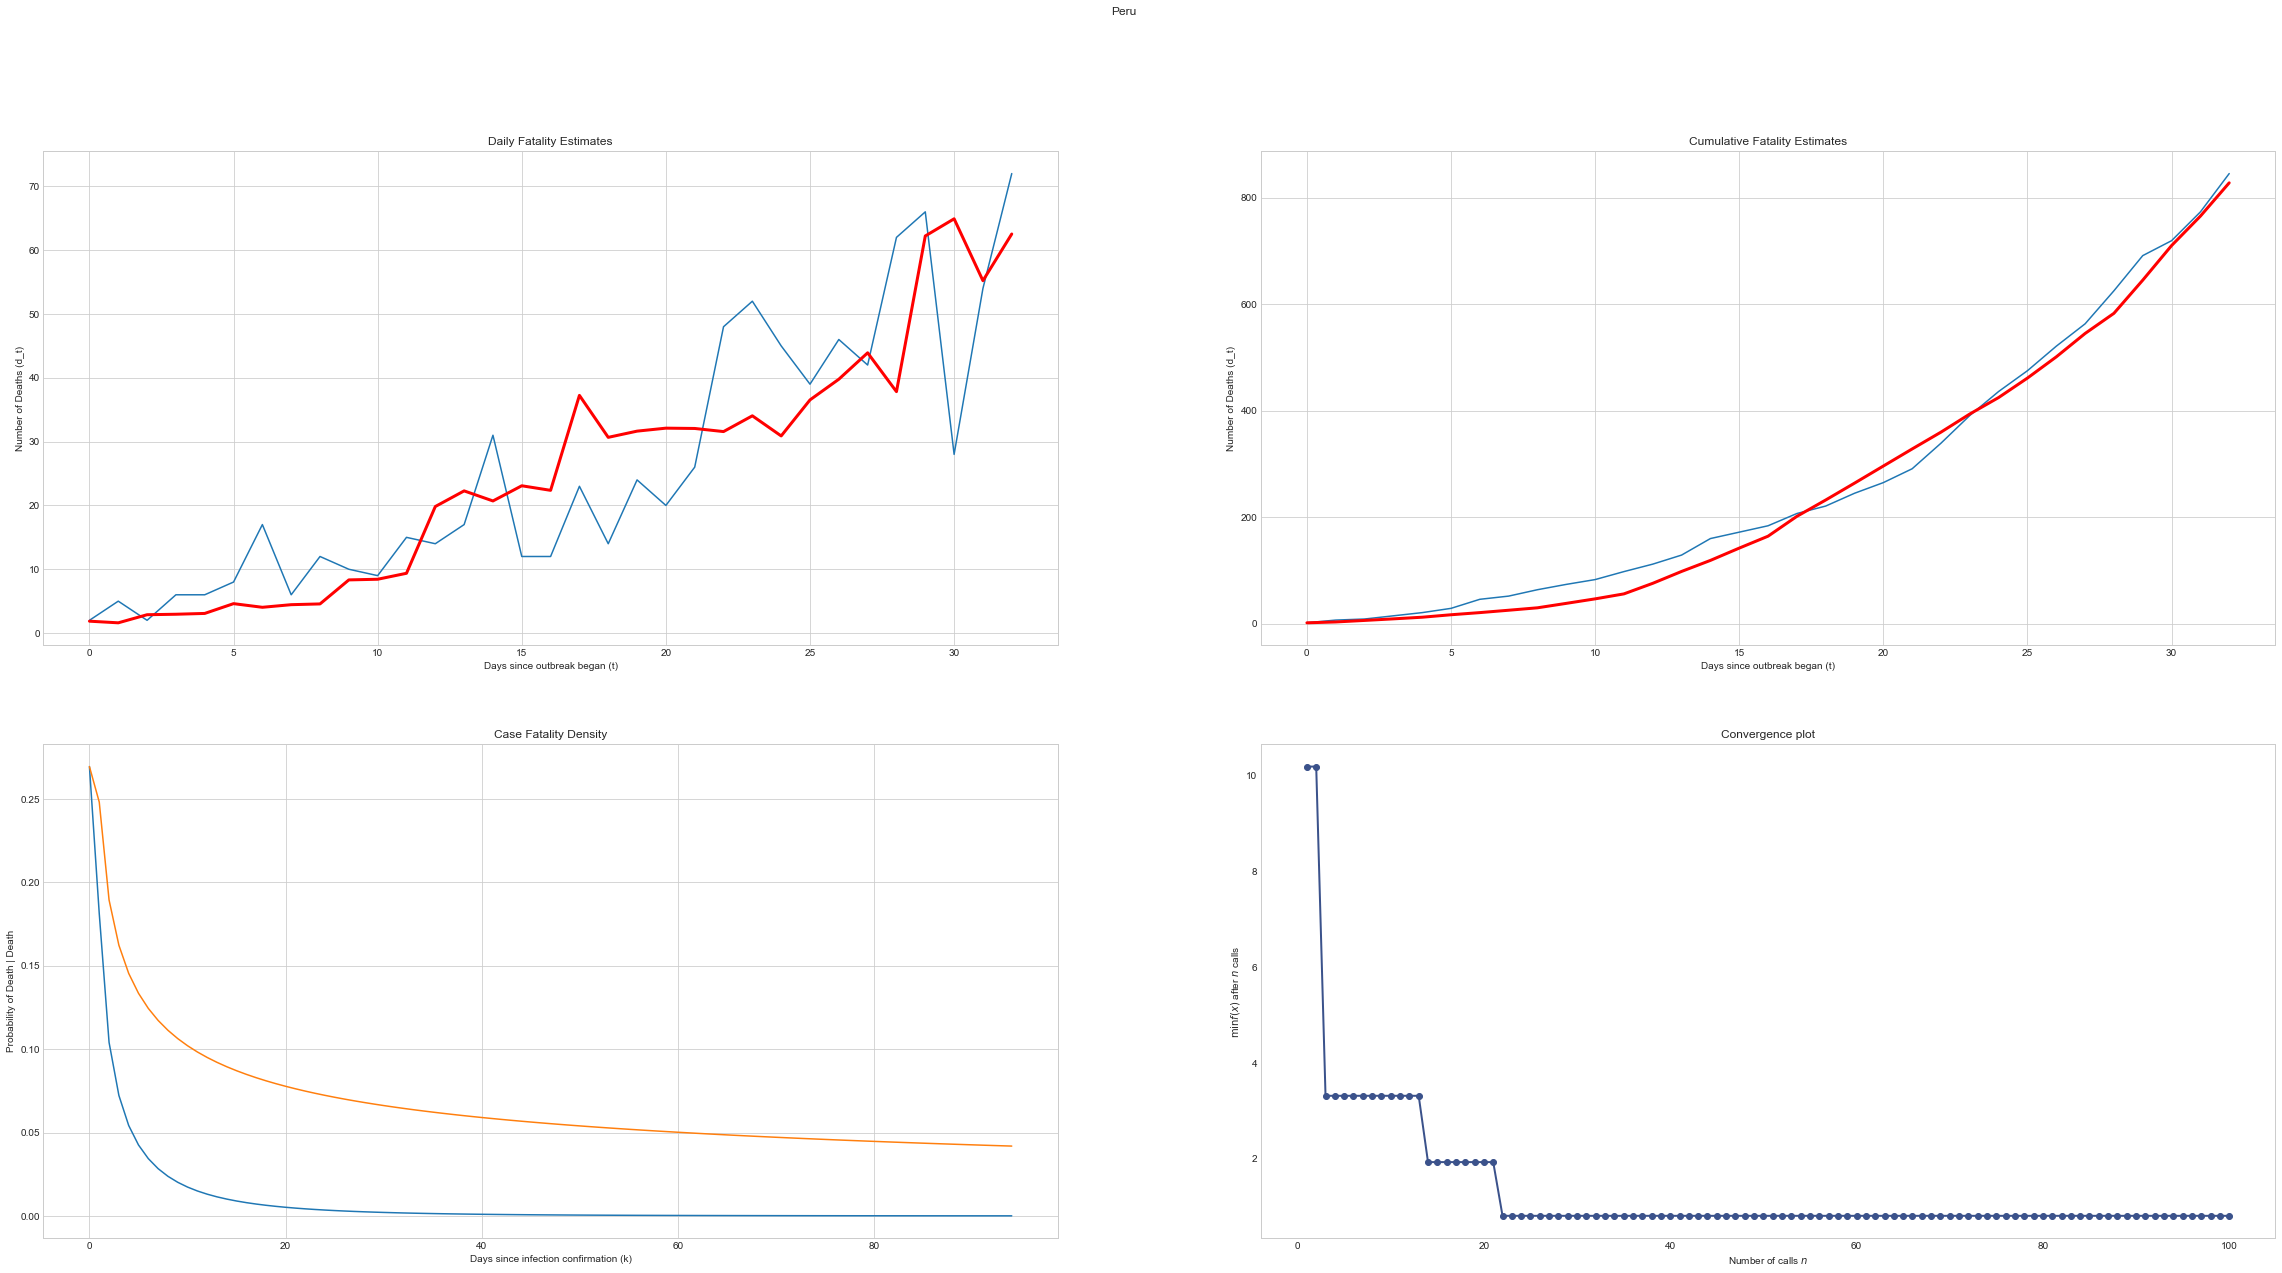

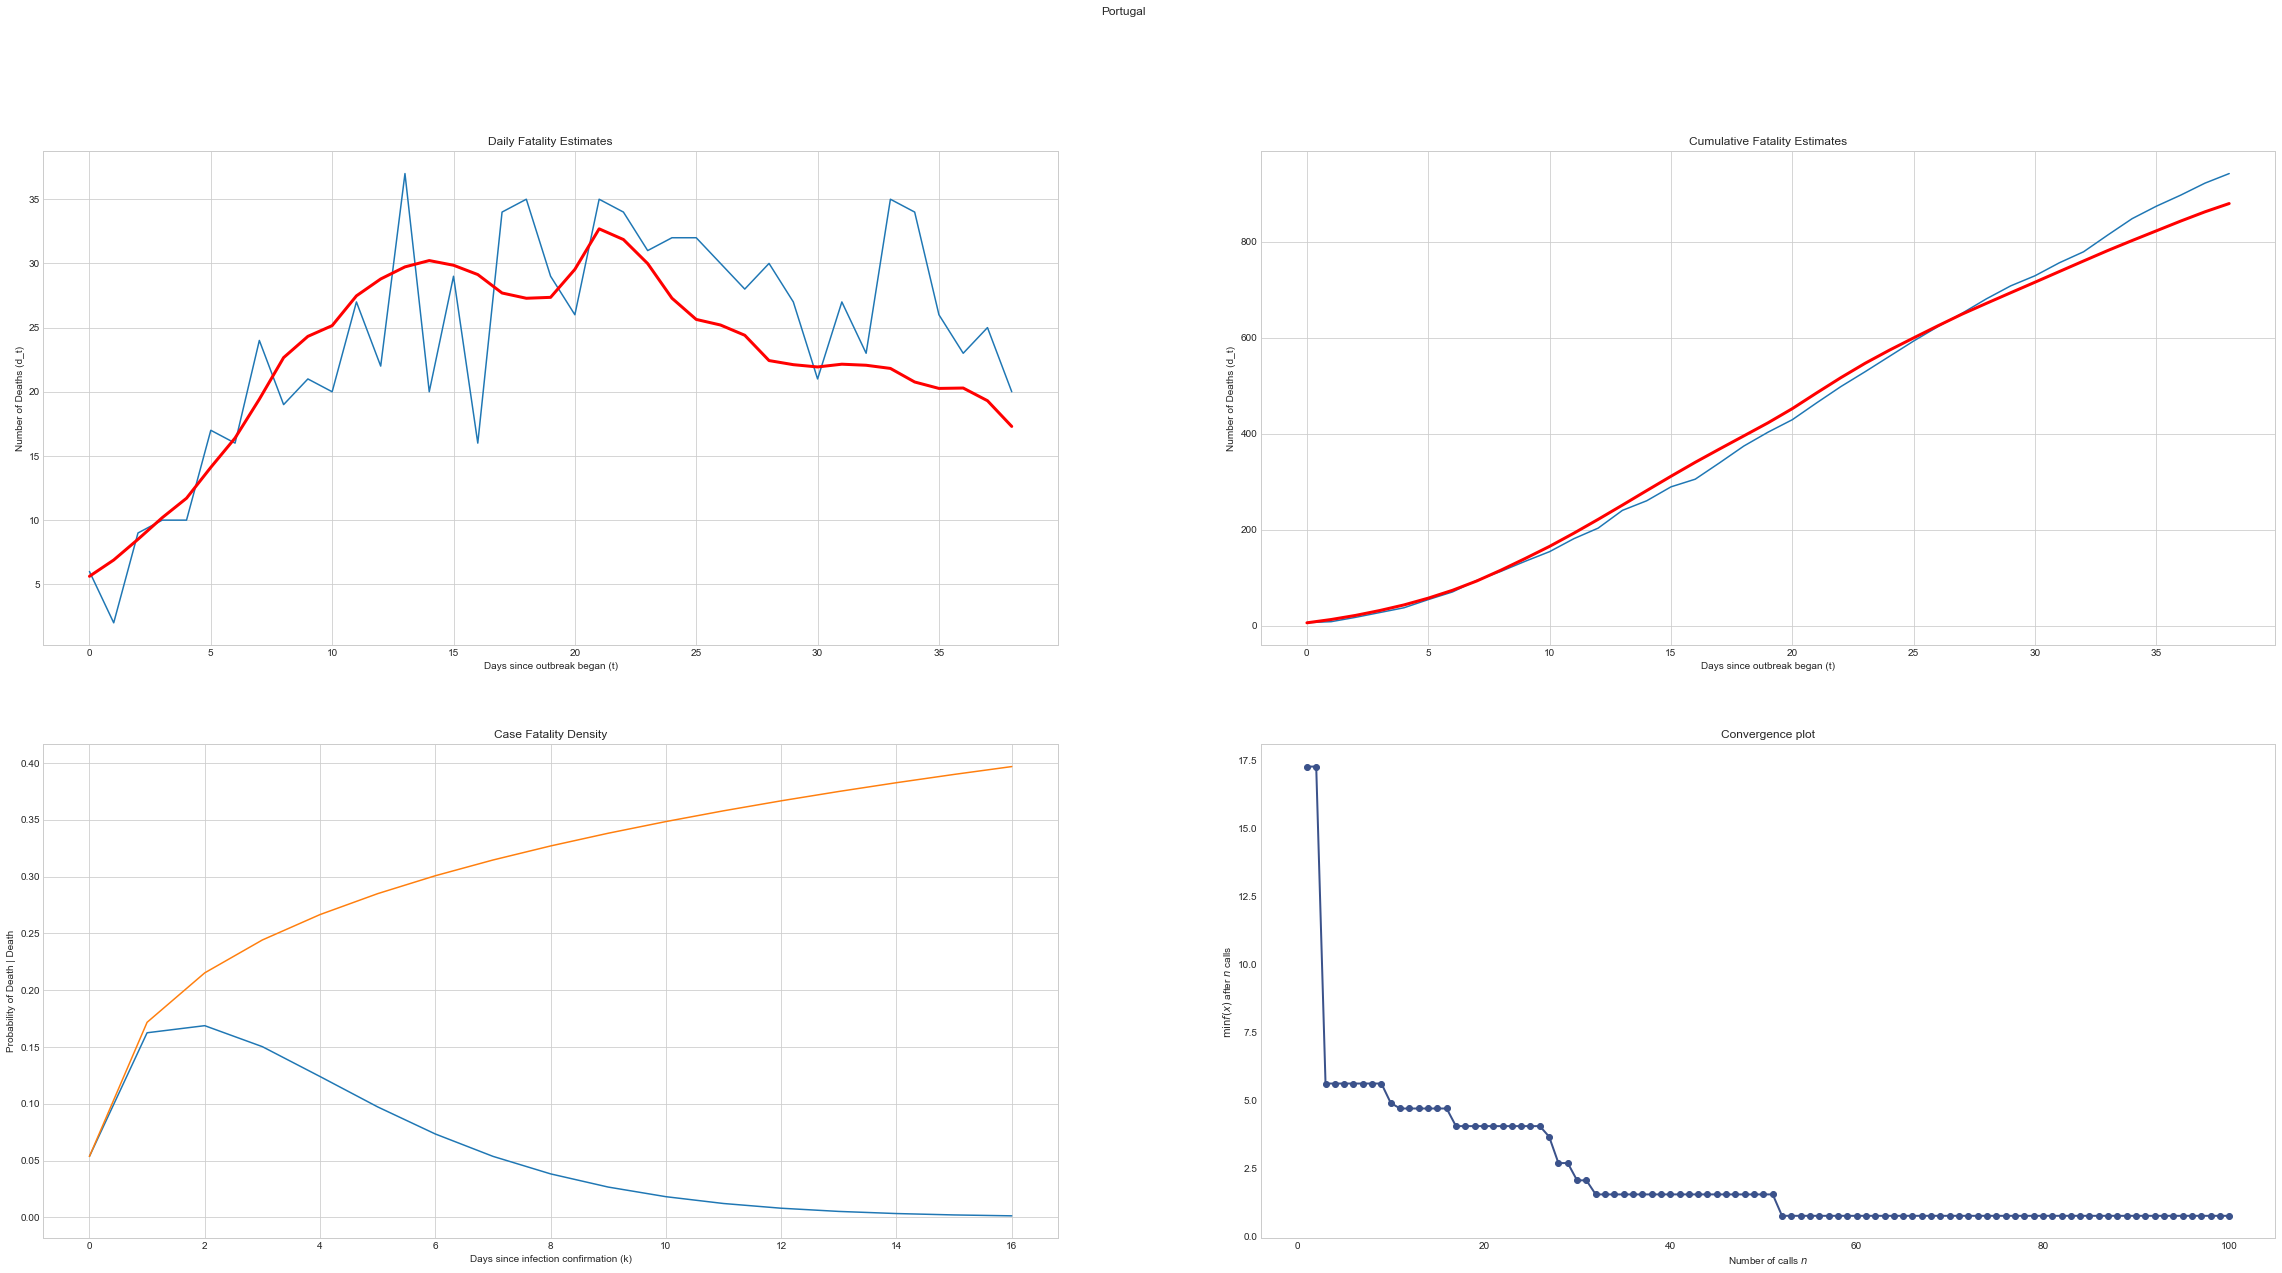

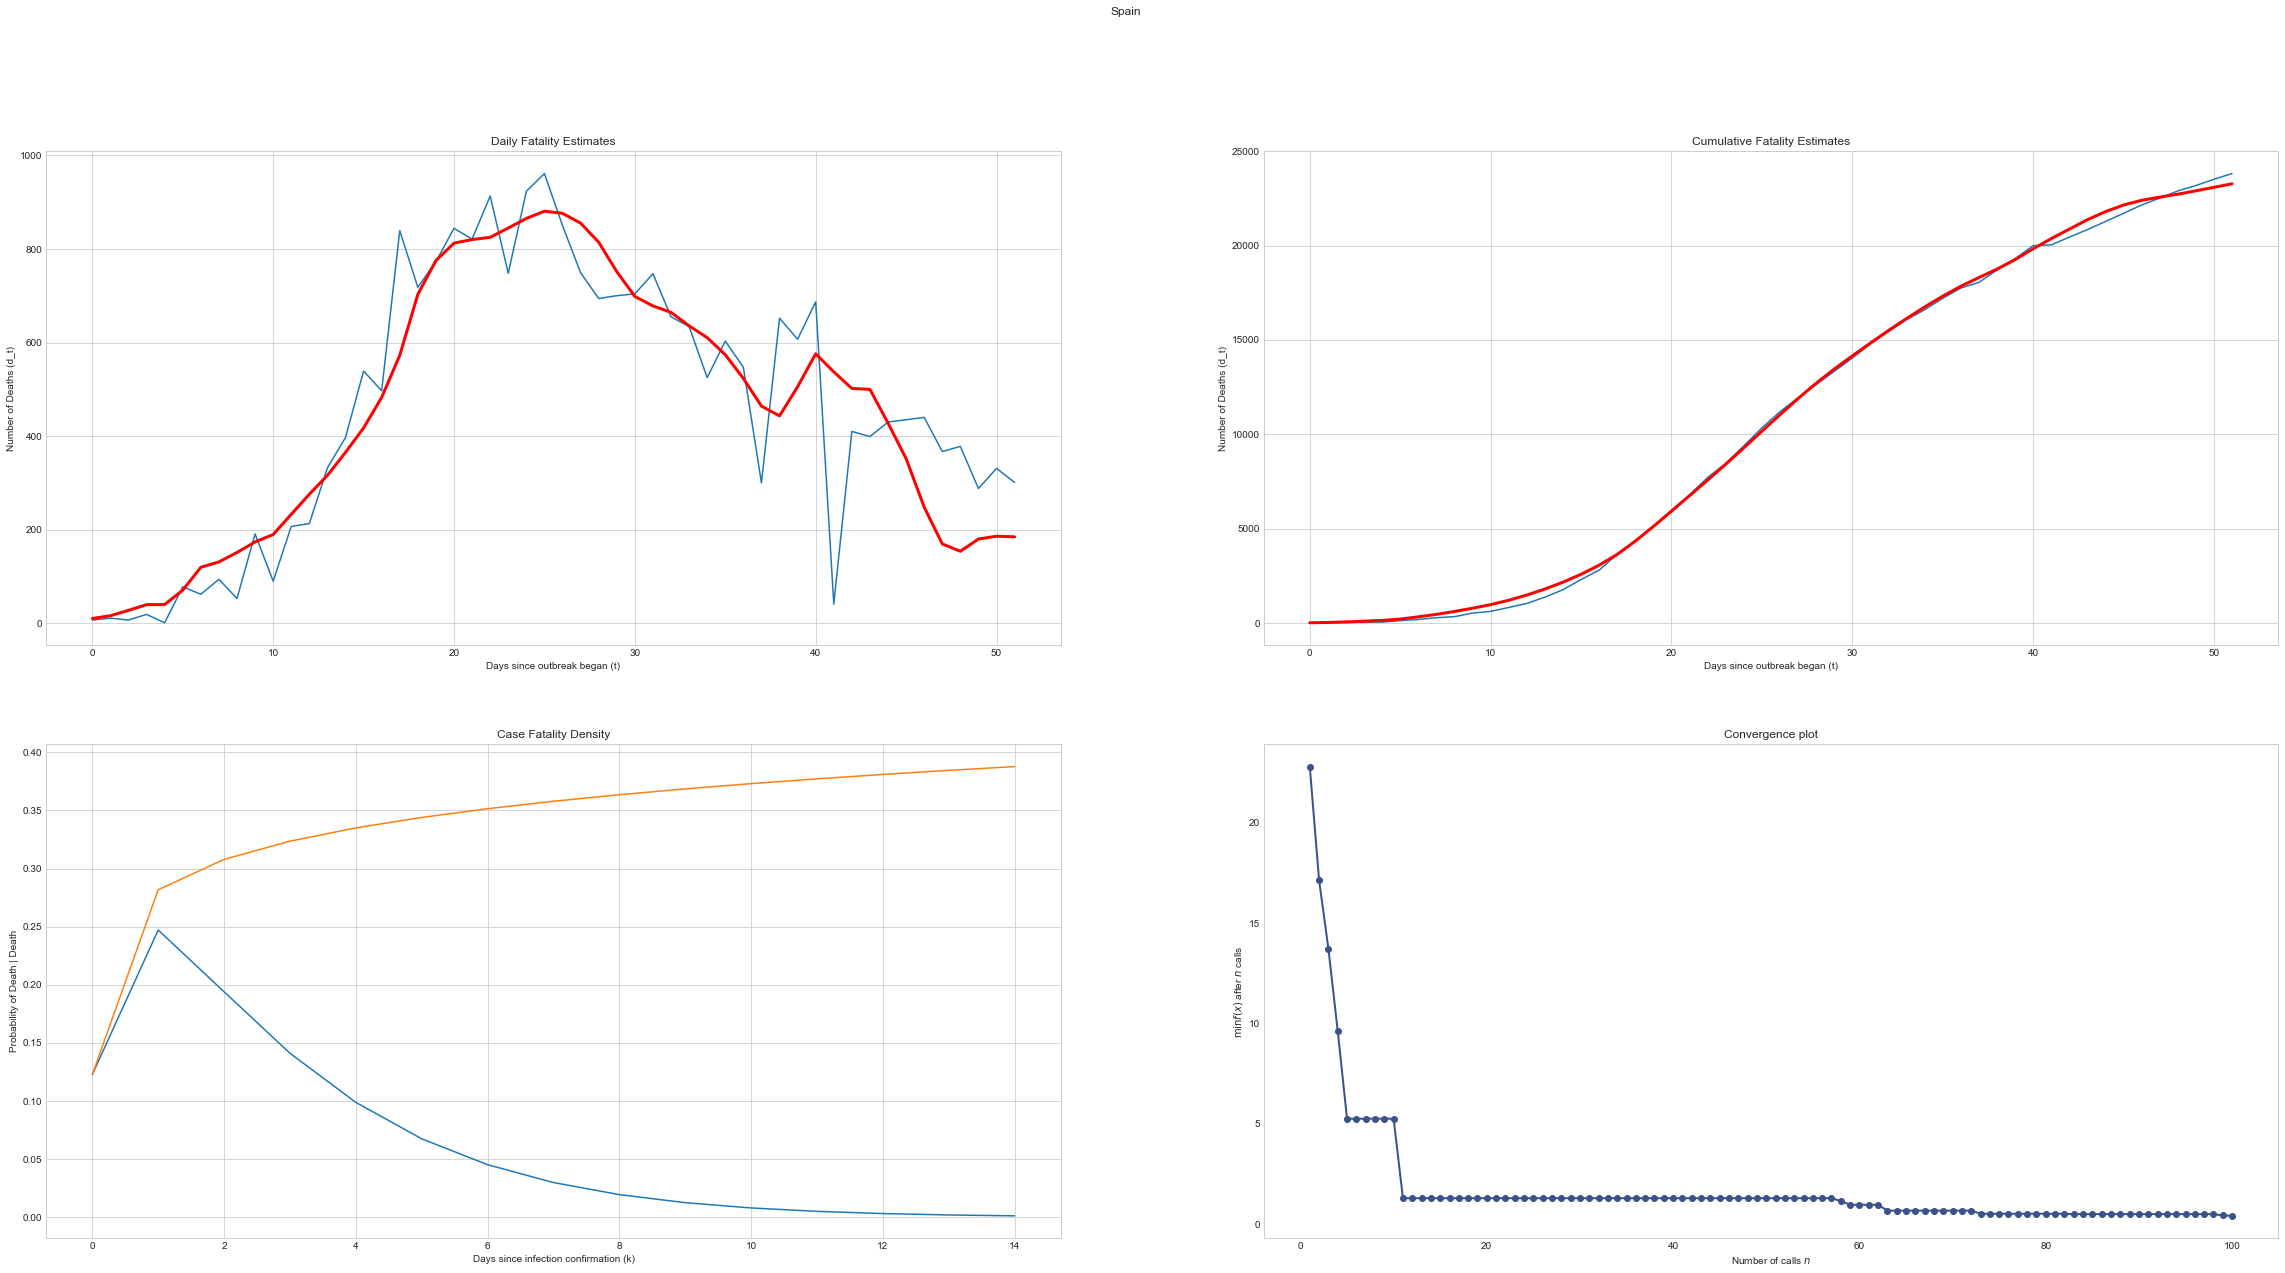

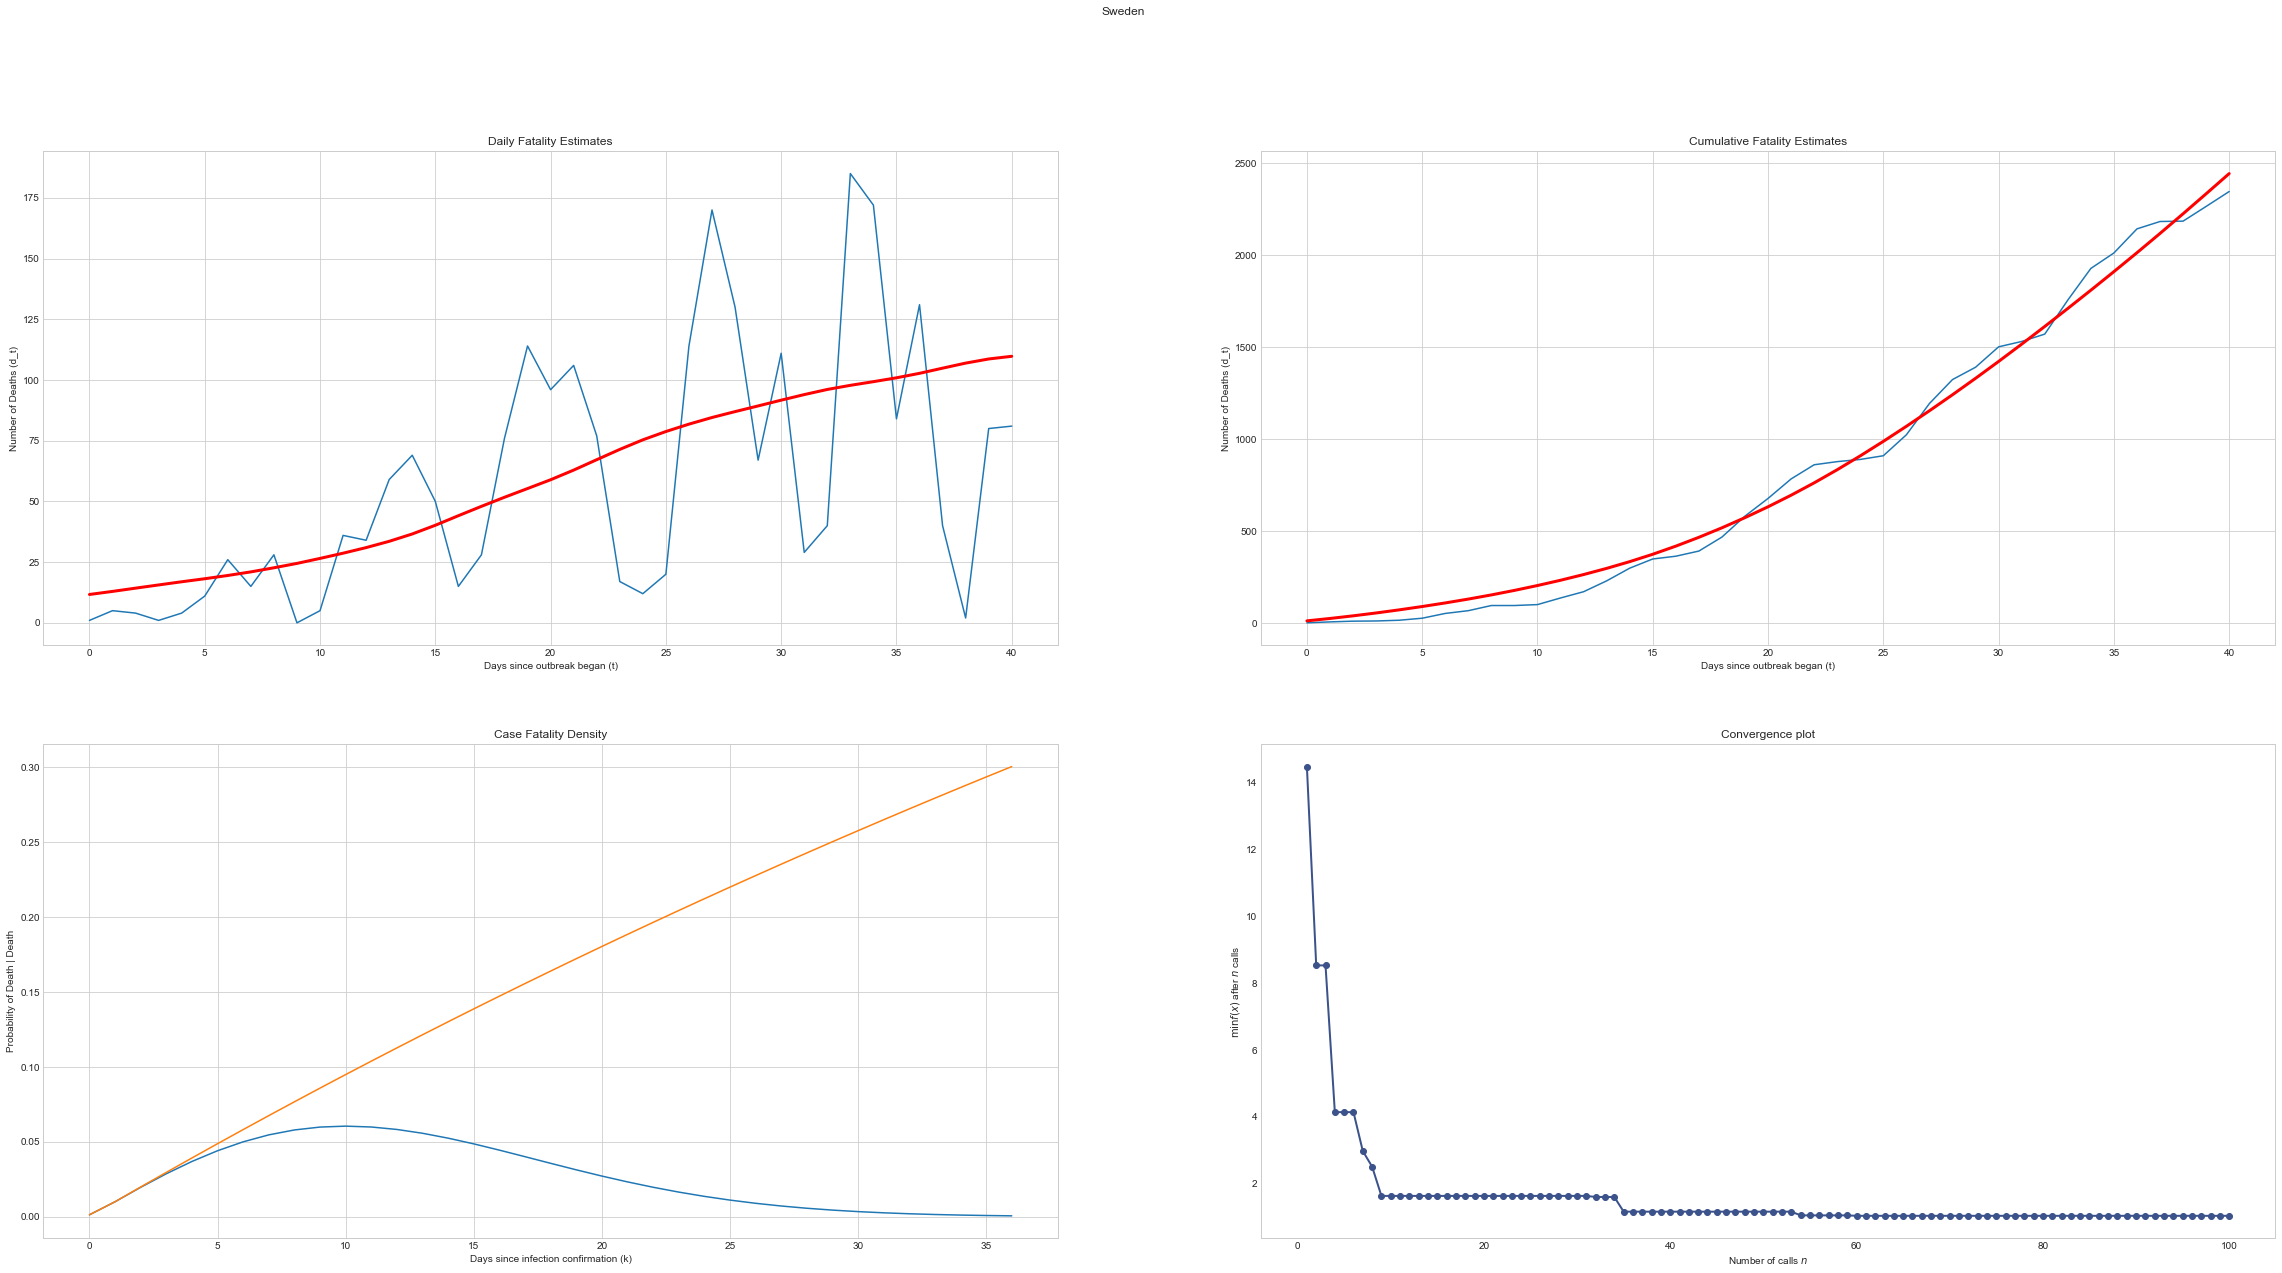

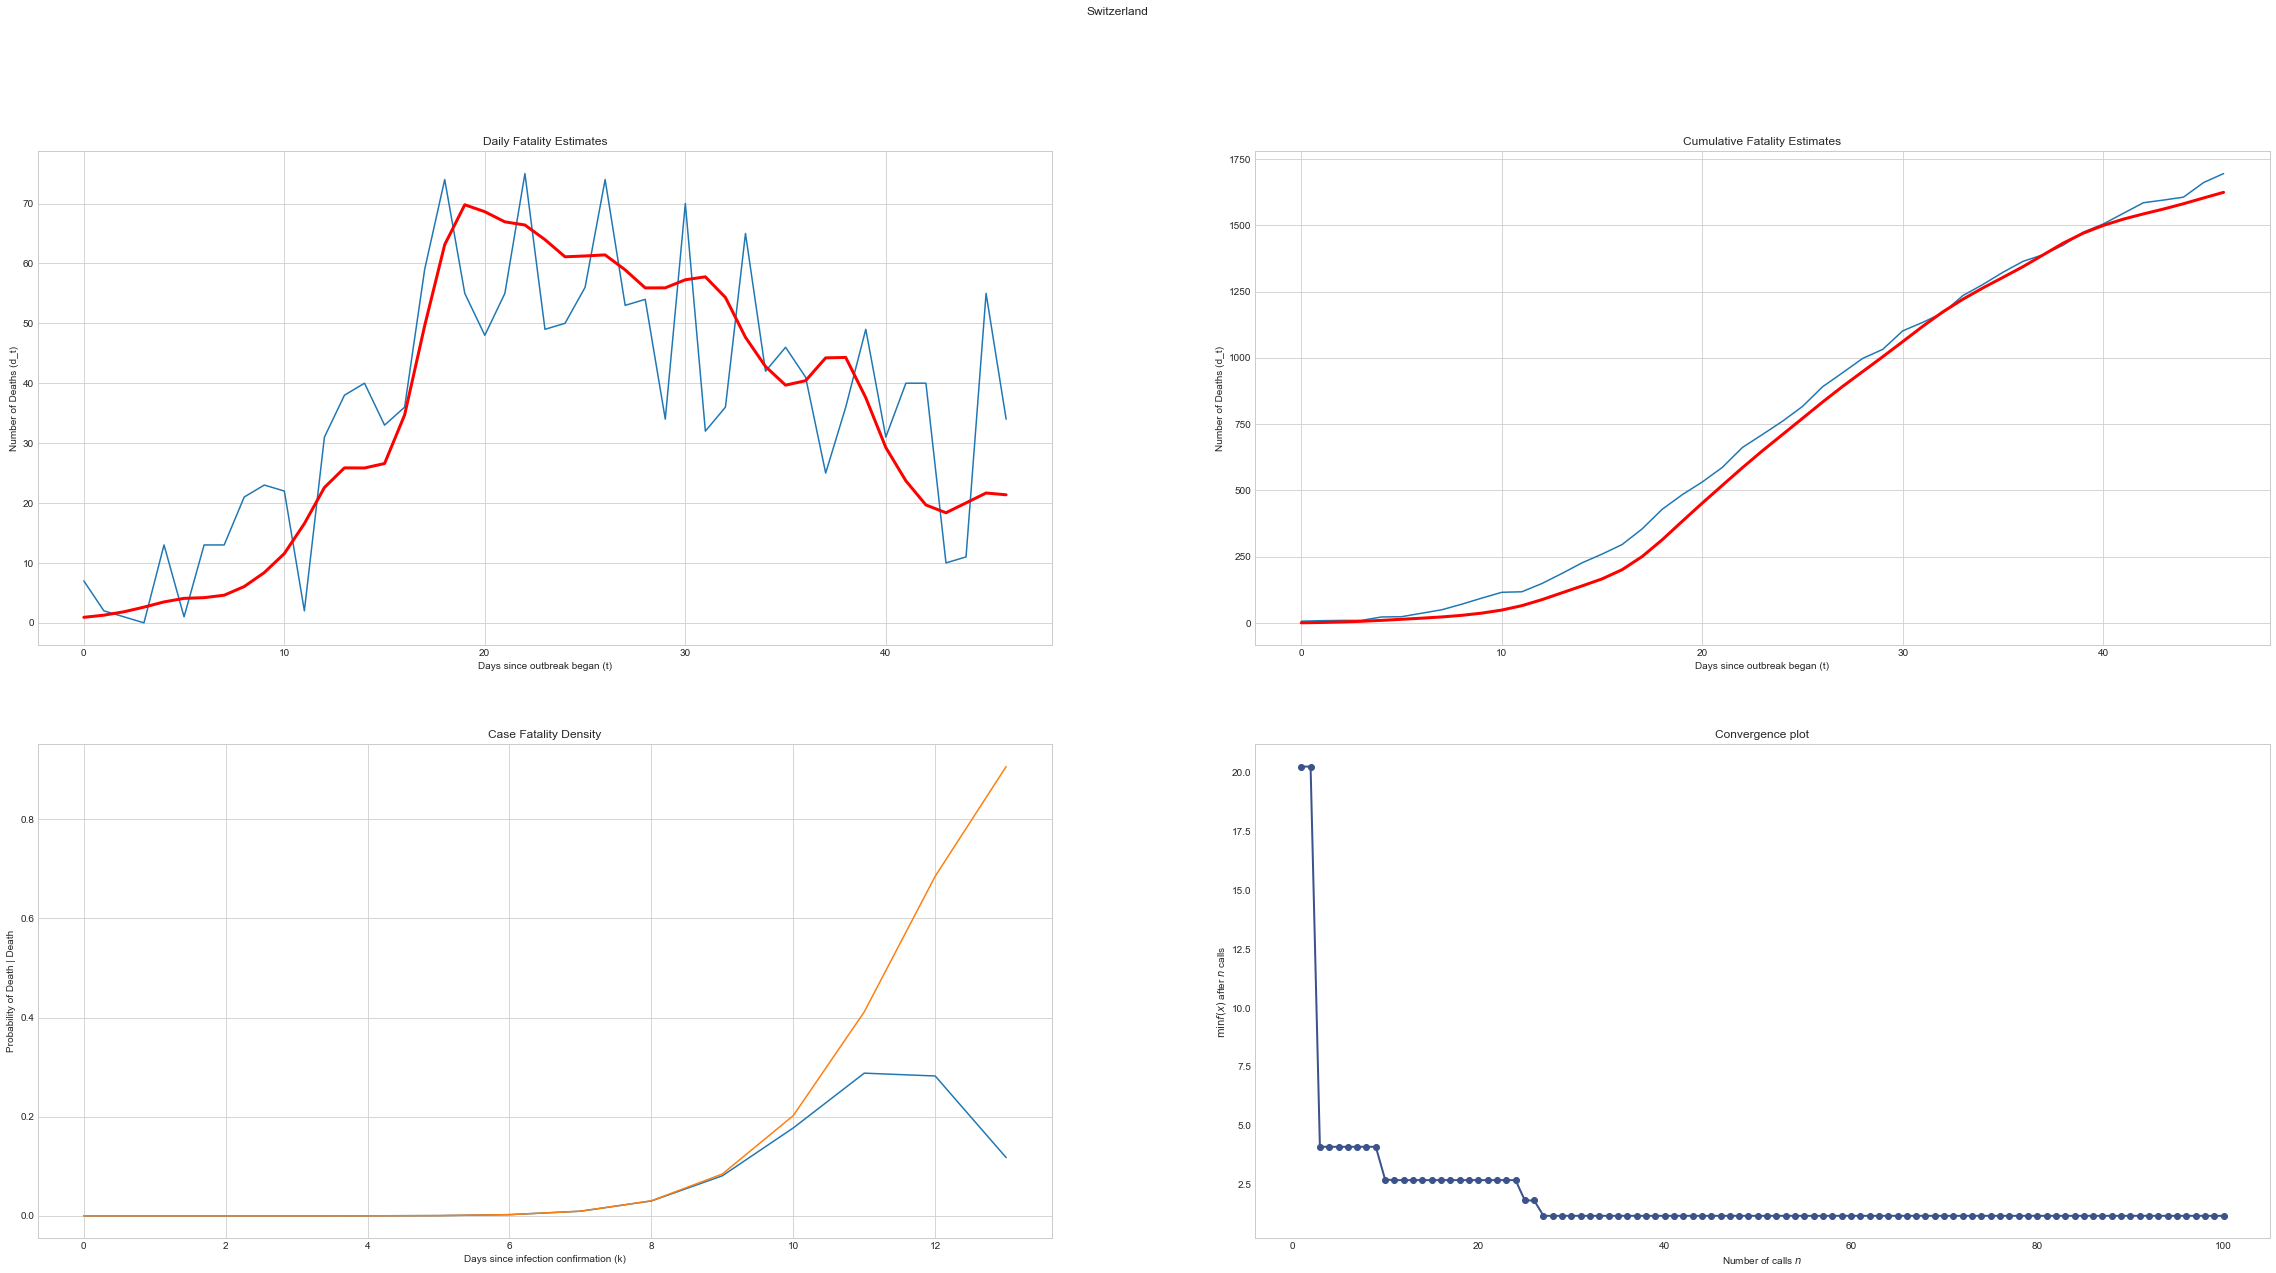

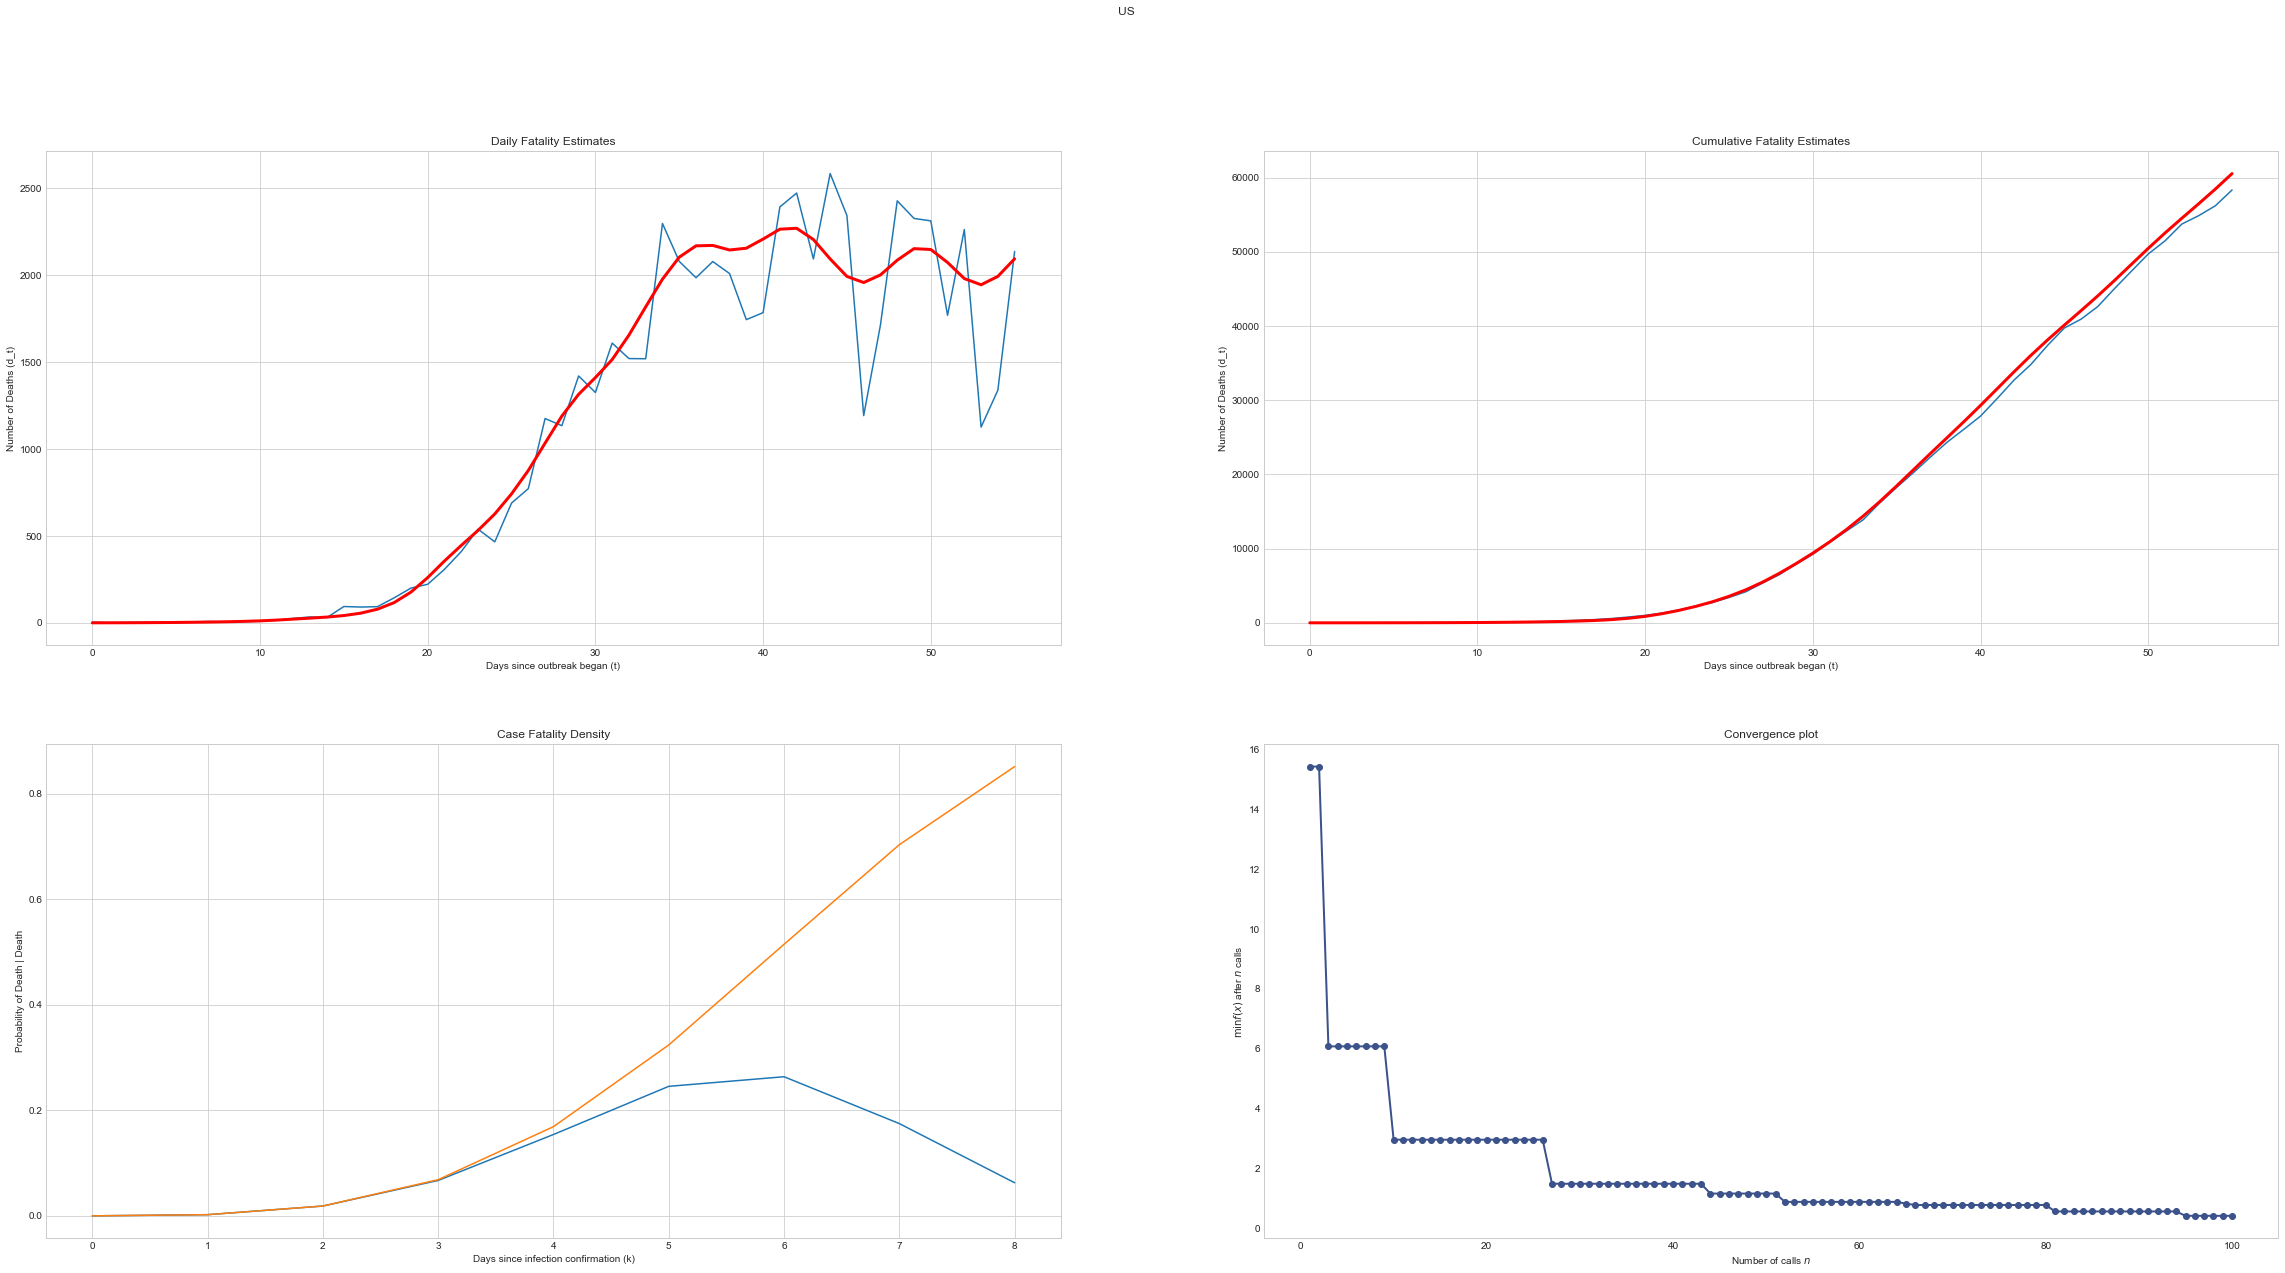

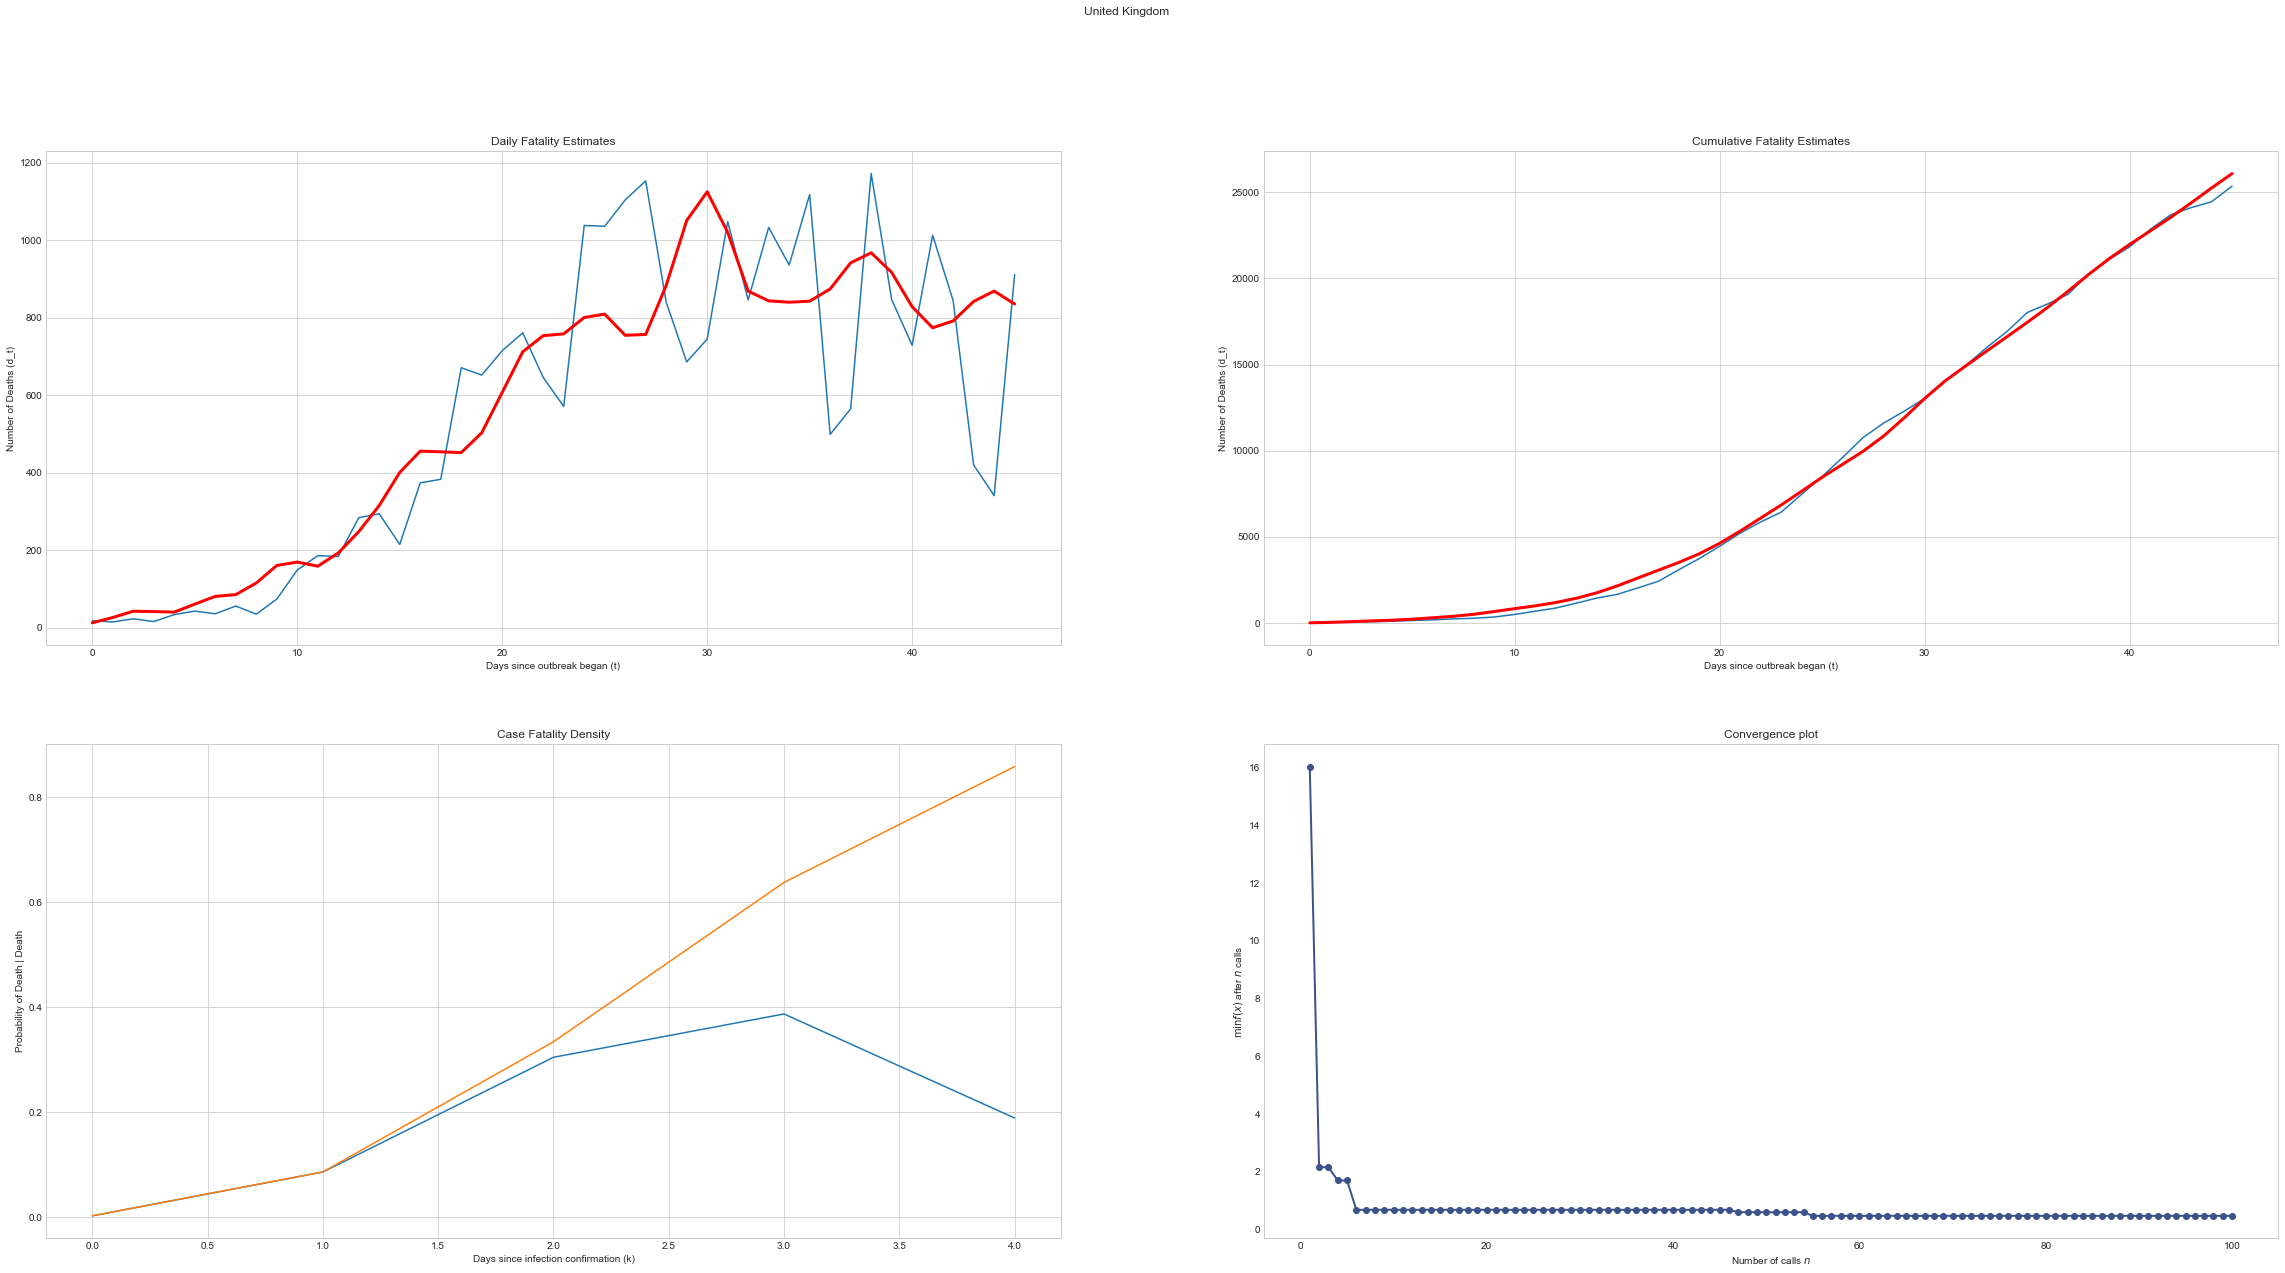

In [322]:
for region, outbreak in pandemic.get_outbreaks(top20_countries).items():
    model = AnalyticalFatalityEstimator(cumulative_error=True, n_days_cutoff=7)
    model.fit(outbreak, skip_optimization=True)
    model.load_result()
    
    model.plot_estimates()